In [1]:
from implementations import *

import numpy as np
import pandas as pd

import zipfile

from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE, trustworthiness
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from transformers import AutoTokenizer, AutoModel
import torch
import umap

# <b><u> Data Loading </u></b> #

We load only the relevant columns since the dataset is already quite large (3 million rows).

In [2]:
zip_file_path = 'BindingDB_All_202409_tsv.zip'
file_path = 'BindingDB_All.tsv'

list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Institution', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('BindingDB_All.tsv') as file:
        data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])

data = pd.DataFrame(data)
data.sample()

C:\Users\hudrya\AppData\Local\Temp\ipykernel_7412\1345508121.py:13: DtypeWarning: Columns (8,9,10,11,12,13,15,23,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


Ligand SMILES             Target Name  \
1858267  CCOc1ccc2CC3N(CCc4cc(OC)c(O)cc34)Cc2c1OC  D(2) dopamine receptor   

        Target Source Organism According to Curator or DataSource Ki (nM)  \
1858267                                       Homo sapiens            159   

        IC50 (nM) Kd (nM) EC50 (nM) kon (M-1-s-1) koff (s-1)  pH  ...  \
1858267       NaN     NaN       NaN           NaN        NaN NaN  ...   

        BindingDB Target Chain Sequence.3 BindingDB Target Chain Sequence.4  \
1858267                               NaN                               NaN   

         BindingDB Target Chain Sequence.5 BindingDB Target Chain Sequence.6  \
1858267                                NaN                               NaN   

        BindingDB Target Chain Sequence.7 BindingDB Target Chain Sequence.8  \
1858267                               NaN                               NaN   

        BindingDB Target Chain Sequence.9 BindingDB Target Chain Sequence.10  \
1858267                               NaN                                NaN   

        BindingDB Target Chain Sequence.11 BindingDB Target Chain Sequence.12  
1858267                                NaN                                NaN  

[1 rows x 26 columns]

# <b><u> Some Insight on Data </u></b> #

<b> The dataset is quite large and includes a variety of organisms. Given the limited computational power of our computers and the complexity of the data (e.g. SMILES, target chains), it is more practical to focus on a subset of organisms rather than processing the entire dataset. </b>

First, we check the number of proteins for each organism. Since we will be performing data cleaning, we will focus on organisms with high protein counts.

In [3]:
# Get the value counts in the organism column
col_name = 'Target Source Organism According to Curator or DataSource'
if col_name in data.columns:
    value_counts = data.groupby(col_name).size().sort_values(ascending=False)
print(value_counts[0:10])

Target Source Organism According to Curator or DataSource
Homo sapiens                      1541025
Rattus norvegicus                  109758
Mus musculus                        49854
Rattus                              33718
Human immunodeficiency virus 1      21780
Bos taurus                          17618
Electrophorus electricus             7921
Cavia porcellus                      7639
Cavia cutleri                        6540
Escherichia coli                     5651
dtype: int64


Some viruses, such as HIV-1, have high counts. Here, we compare their counts and identify the institutions that studied them.

total number of virus associated protein: 42342


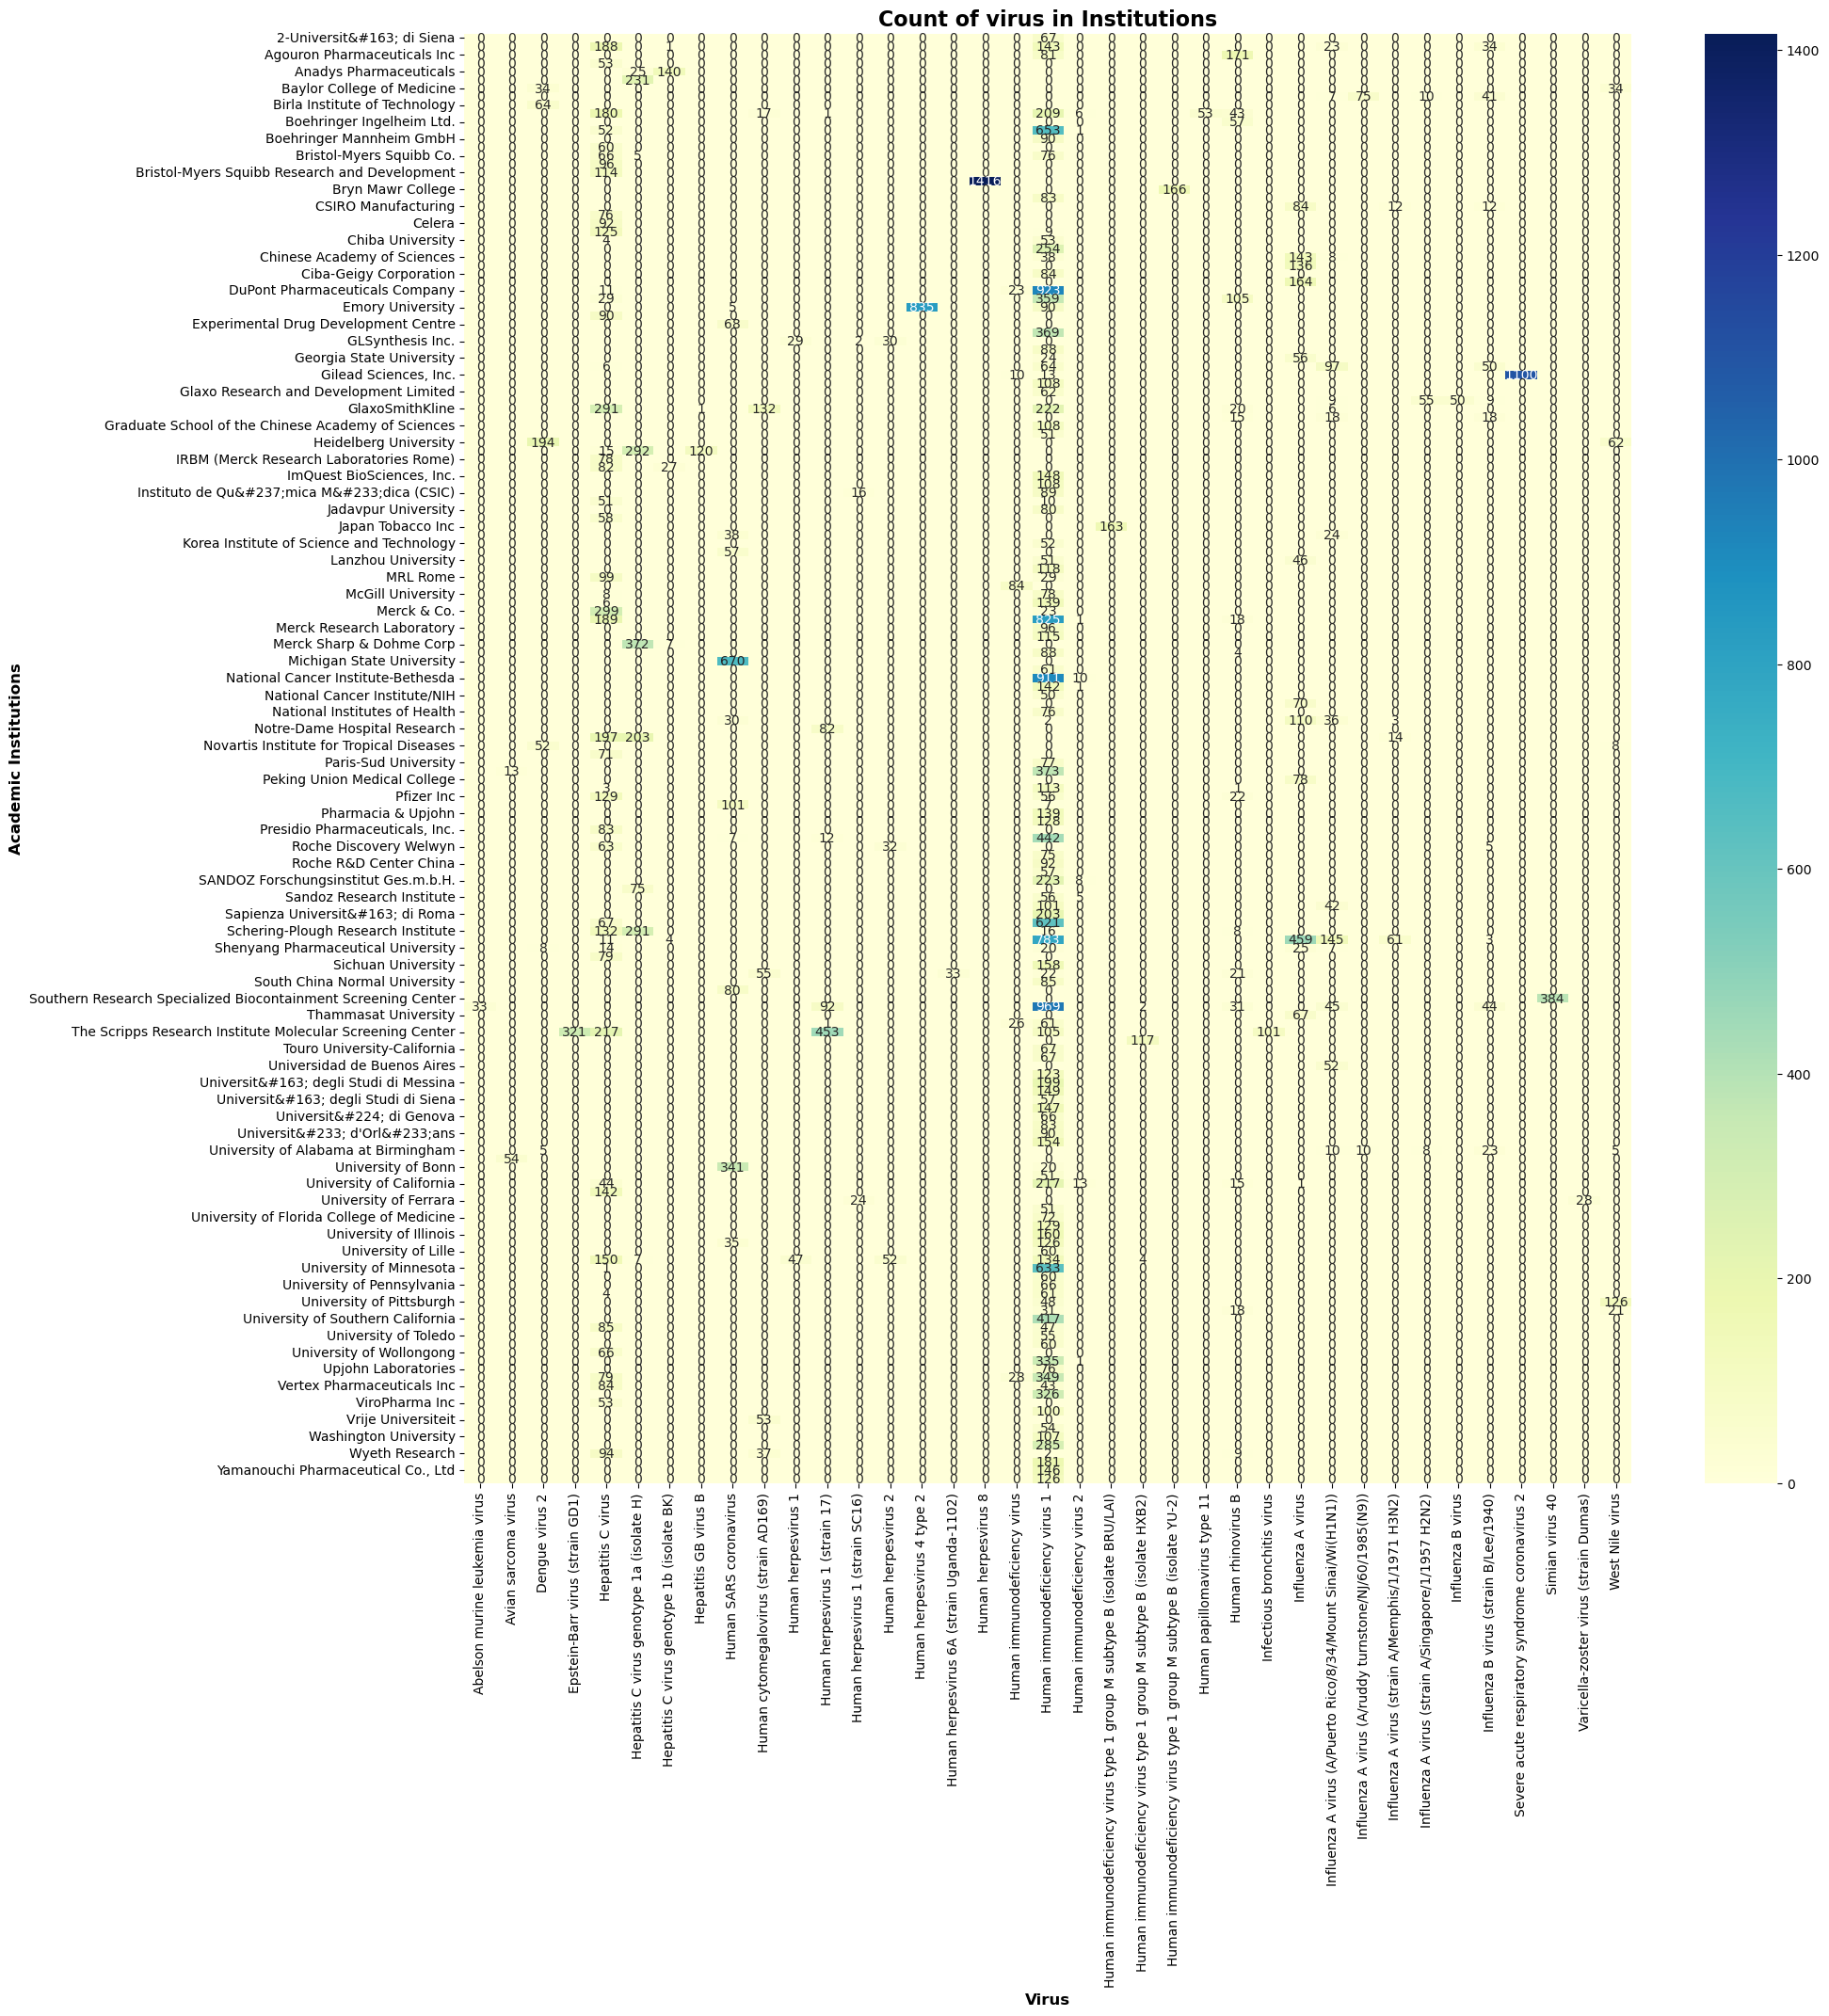

In [4]:
virus_data = data[data['Target Source Organism According to Curator or DataSource'].str.contains('virus', case=False, na=False)]

print(f'total number of virus associated protein: {virus_data["Target Source Organism According to Curator or DataSource"].value_counts().sum()}')

virus_counts = pd.crosstab(virus_data['Institution'], 
                           virus_data['Target Source Organism According to Curator or DataSource'])

virus_counts = virus_counts.loc[:, virus_counts.sum(axis=0) >= 50] 
virus_counts = virus_counts[virus_counts.sum(axis=1) >= 50]

plt.figure(figsize=(20, 20))
sns.heatmap(virus_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of virus in Institutions', fontweight=800,fontsize=16)
plt.xlabel('Virus',fontweight=800,fontsize=12)
plt.ylabel('Academic Institutions', fontweight=800,fontsize=12)
plt.show()

Among all viruses, HIV-1 is the only one with sufficient Ki data and is extensively studied by numerous labs. In contrast, the available Kd data is too sparse to be useful.

In [5]:
non_nan_ki = virus_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (all viruses): ', non_nan_ki)

non_nan_kd = virus_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (all viruses): ', non_nan_kd)

Numbers of data containing Ki information (all viruses):  6415
Numbers of data containing Kd information (all viruses):  406


In [6]:
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)

non_nan_ki = hiv_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (Hiv1): ', non_nan_ki)

non_nan_kd = hiv_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (Hiv1): ', non_nan_kd)

Numbers of data containing Ki information (Hiv1):  4350
Numbers of data containing Kd information (Hiv1):  237


# <b><u> Focusing on HIV-1 </u></b> #

<b> Here we check if HIV-1 data is sufficient and viable to train a machine learning model. </b>

Some data rows contain Ki values like '<100' or '>30000', which are difficult to interpret. Therefore, we choose to drop these rows.

In [7]:
# Choosing the metric which is the most present
metric = 'Ki (nM)'

# Filter for Hiv1
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)
print(f'prior size: {hiv_data.shape[0]}')

mask_invalid_values = hiv_data[metric].str.contains('<',case=False,na=False) | hiv_data[metric].str.contains('>',case=False,na=False) | hiv_data[metric].isna()
print(f'final size: {hiv_data.shape[0] - mask_invalid_values.sum()}')
hiv_data = hiv_data[~mask_invalid_values]

prior size: 21780
final size: 4171


Let's check the distribution of Ki. Ideally, it should be diverse to train a machine learning model.

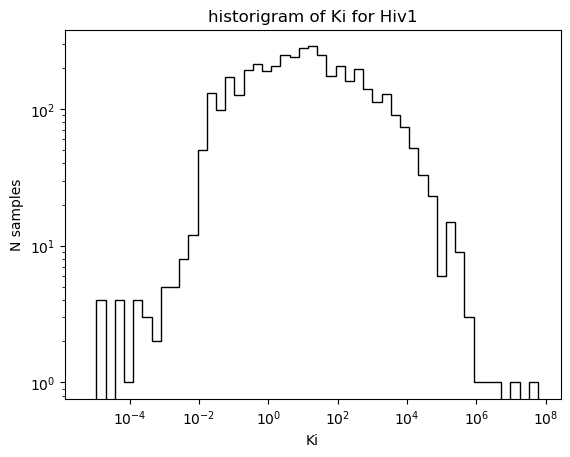

In [8]:
metric_numeric = pd.to_numeric(hiv_data[metric], errors='coerce').dropna()
bins = np.logspace(np.log10(metric_numeric.min()), np.log10(metric_numeric.max()), 50)
plt.hist(metric_numeric, bins=bins, edgecolor="black", histtype="step", log=True)

plt.xscale('log')
plt.title('historigram of Ki for Hiv1')
plt.xlabel('Ki')
plt.ylabel('N samples')
plt.show()

The data contains duplicate ligands and targets. For the machine learning model, it would be best to start by training on a single abundant unique target to refine the model and then gradually incorporate the complexity of multitarget learning. Additionally, it is important to ensure diversity among the proteins, as we would like the model to not underfit or overfit.

Number of Ligand compounds in HIV1:  5638


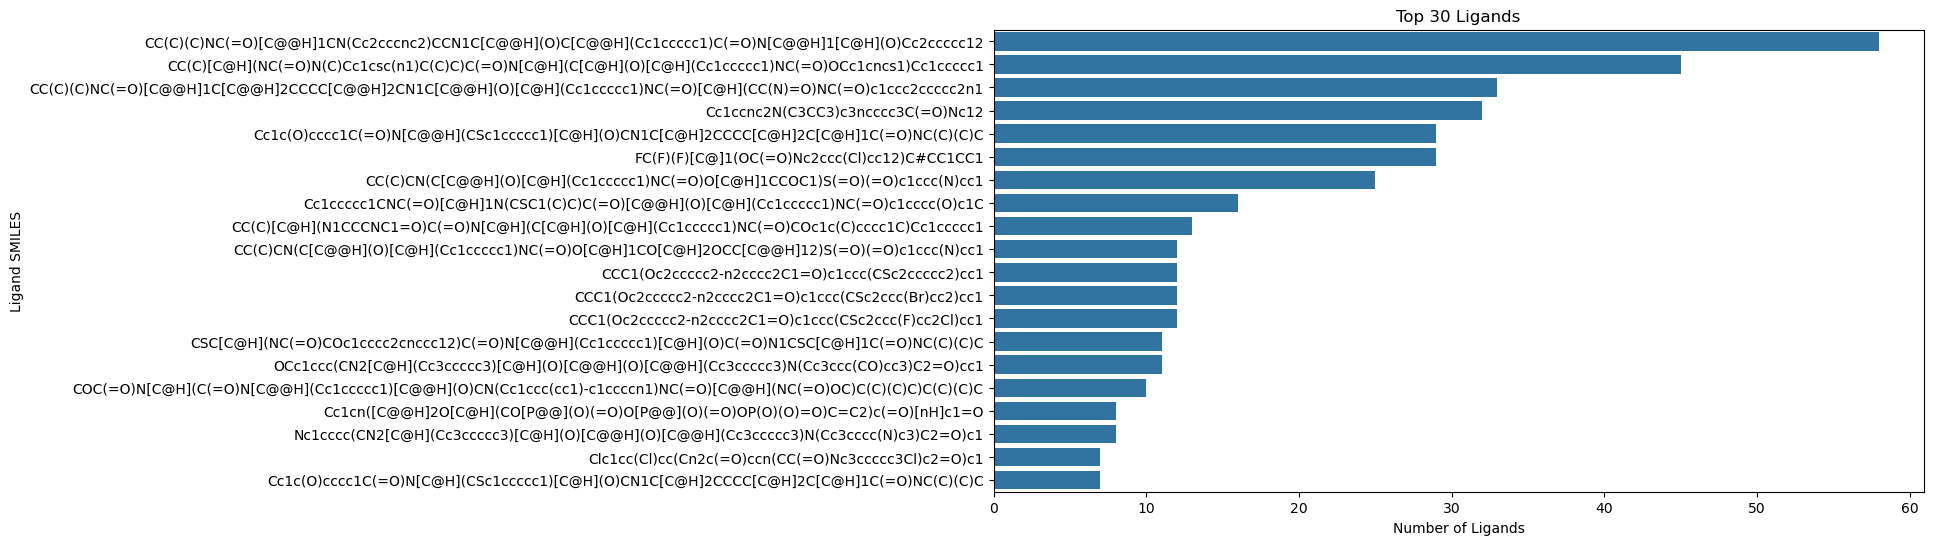

In [9]:
target_counts = hiv_data.groupby('Ligand SMILES').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of Ligand compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Ligand SMILES', data=target_counts.head(20))
plt.title('Top 30 Ligands')
plt.xlabel('Number of Ligands')
plt.ylabel('Ligand SMILES')
plt.show()

Number of targets of the compounds in HIV1:  126


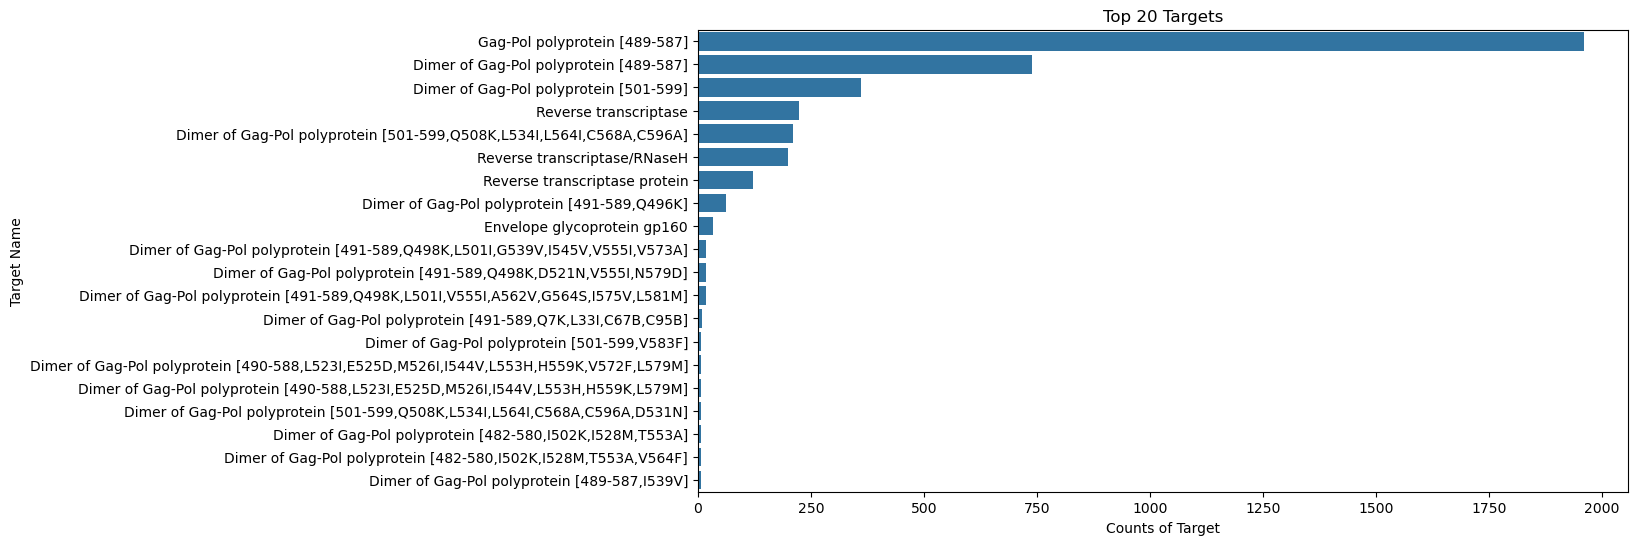

In [10]:
# Check the targets for Hiv1
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20))
plt.title('Top 20 Targets')
plt.xlabel('Counts of Target')
plt.ylabel('Target Name')
plt.show()

Some targets consist of multiple chains, which we need to account for in the machine learning model. We could either concatenate the chains of such targets and treat them as a single entity or handle them as separate parameters. This has not yet been decided.

In [11]:
col_name = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
seq_col = 'BindingDB Target Chain Sequence'

if col_name in hiv_data.columns and seq_col in hiv_data.columns:
    unique_data = hiv_data.drop_duplicates(subset=[seq_col])
    count_Nchain = unique_data[col_name].value_counts()

count_Nchain

Number of Protein Chains in Target (>1 implies a multichain complex)
1    56
2     7
Name: count, dtype: int64

# <u><b>CLUSTERING</b></u>

<b> To train a machine learning model, we must provide it with continuous or discrete data. For ligands, the only relevant information available is SMILES strings. Additionally, the data needs to be suitable for training, with data points that are differentiable.

To obtain continuous data, we first embed the SMILES using one of two algorithms: BERT embedding or Morgan Fingerprint.

Next, for visualisation purpose and due to computational constraints, we reduce the dimensionality of the data to three using one of two algorithms: t-SNE or UMAP. Both algorithms have their advantages and disadvantages.

To draw final conclusions, we perform k-means clustering on the four combinations (BERT+t-SNE, BERT+UMAP, Morgan Fingerprint+t-SNE, Morgan Fingerprint+UMAP). We visually and numerically evaluate the best clusters with scores (silhouette score, Kullback-Leibler divergence for t-SNE, trustworthiness score for UMAP and normalized entropy). Clear, well-separated and balanced clusters are preferred. </b>

## <b>Clustering with Morgan Fingerprints: </b> ##

Advantages:

- The embedding is based on the environment of each atom (the surrounding atoms), providing a direct connection to the molecular structure.
- Produces a fixed vector size for each molecule, which can aid in clustering.
- Well-established and widely tested.

Inconveniences:

- Captures either local or global structures, depending on the radius (a hyperparameter) of the atom environments.
- Better suited for classification tasks; however, dimensionality reduction can mitigate this limitation.
- Highly sensitive to the radius parameter. If the radius is too large or too small, it can result in either overly sparse clusters or clusters that are difficult to differentiate.

More info on Morgan Fingerprints can be found in the implementations.

Note: for dimension reduction of Morgan Fingerprints, we will use jaccard metric as it is suited for binary vectors

In [12]:
smiles_list = hiv_data['Ligand SMILES'].unique().tolist()

### Using TSNE: Generate Fingerprints + Compute and Plot Scores ###

Here and for each of subsequent combinations, we will evaluate the best number of clusters for k-means based on elbow method and silhouette score.

Radius = 2
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 3
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 4
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 5
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


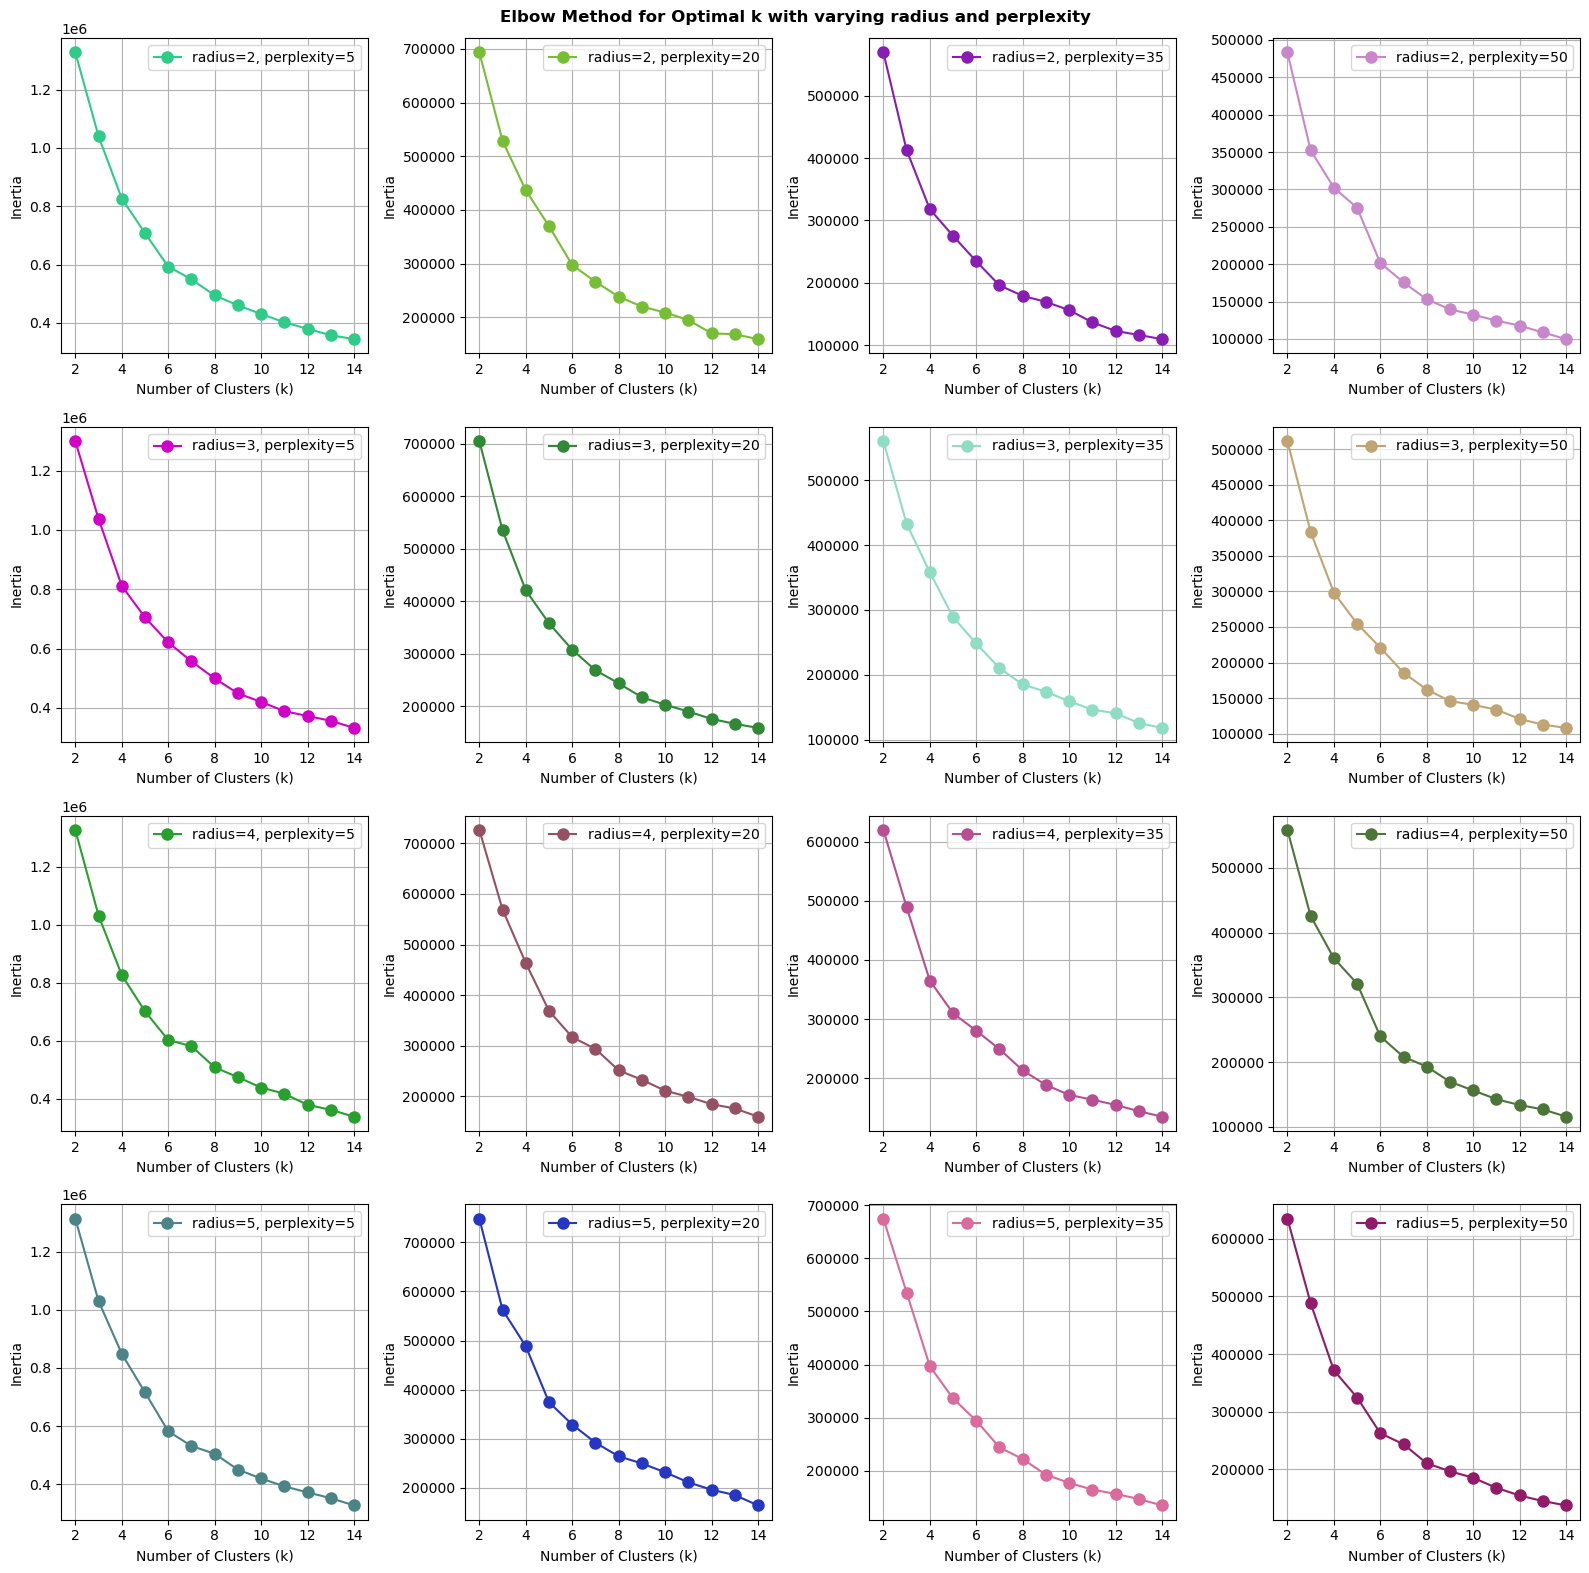

In [ ]:
# For t-SNE, an important parameter to tune is perplexity (effective number of neighbors).
# We also tune the radius for Morgan Fingerprints

radiuses = [2,3,4,5]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsn_results, KLs, s_scores = plot_elbow_curve(
    method='tsne',
    original_data=smiles_list,
    param1_list=radiuses,
    param2_list=perplexities,
    Ks=Ks,
    param1_name='radius',
    param2_name='perplexity',
    metric='jaccard',
    generate_MF=True
)

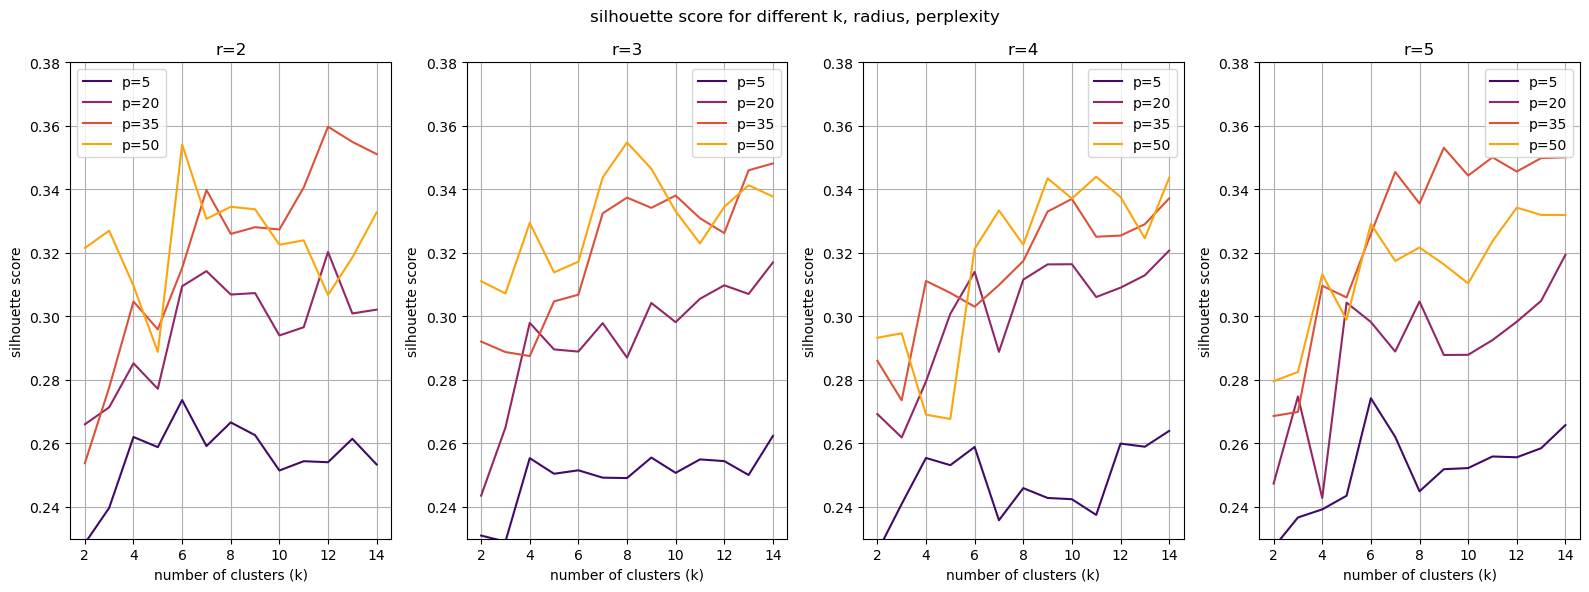

In [14]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.38),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

### Choosing best clusters from plots + Observing according distributions ###

Here, we first choose the best k for each combination manually and then plot the distribution of the clusters. The normalized entropy score is used to evaluate good distributions across the clusters (see implementations to have more info on this metric).

In [15]:
# Choose best k for each radius and perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,12,12,6],
           [4,9,8,8],
           [6,6,10,9],
           [6,8,12,9]]

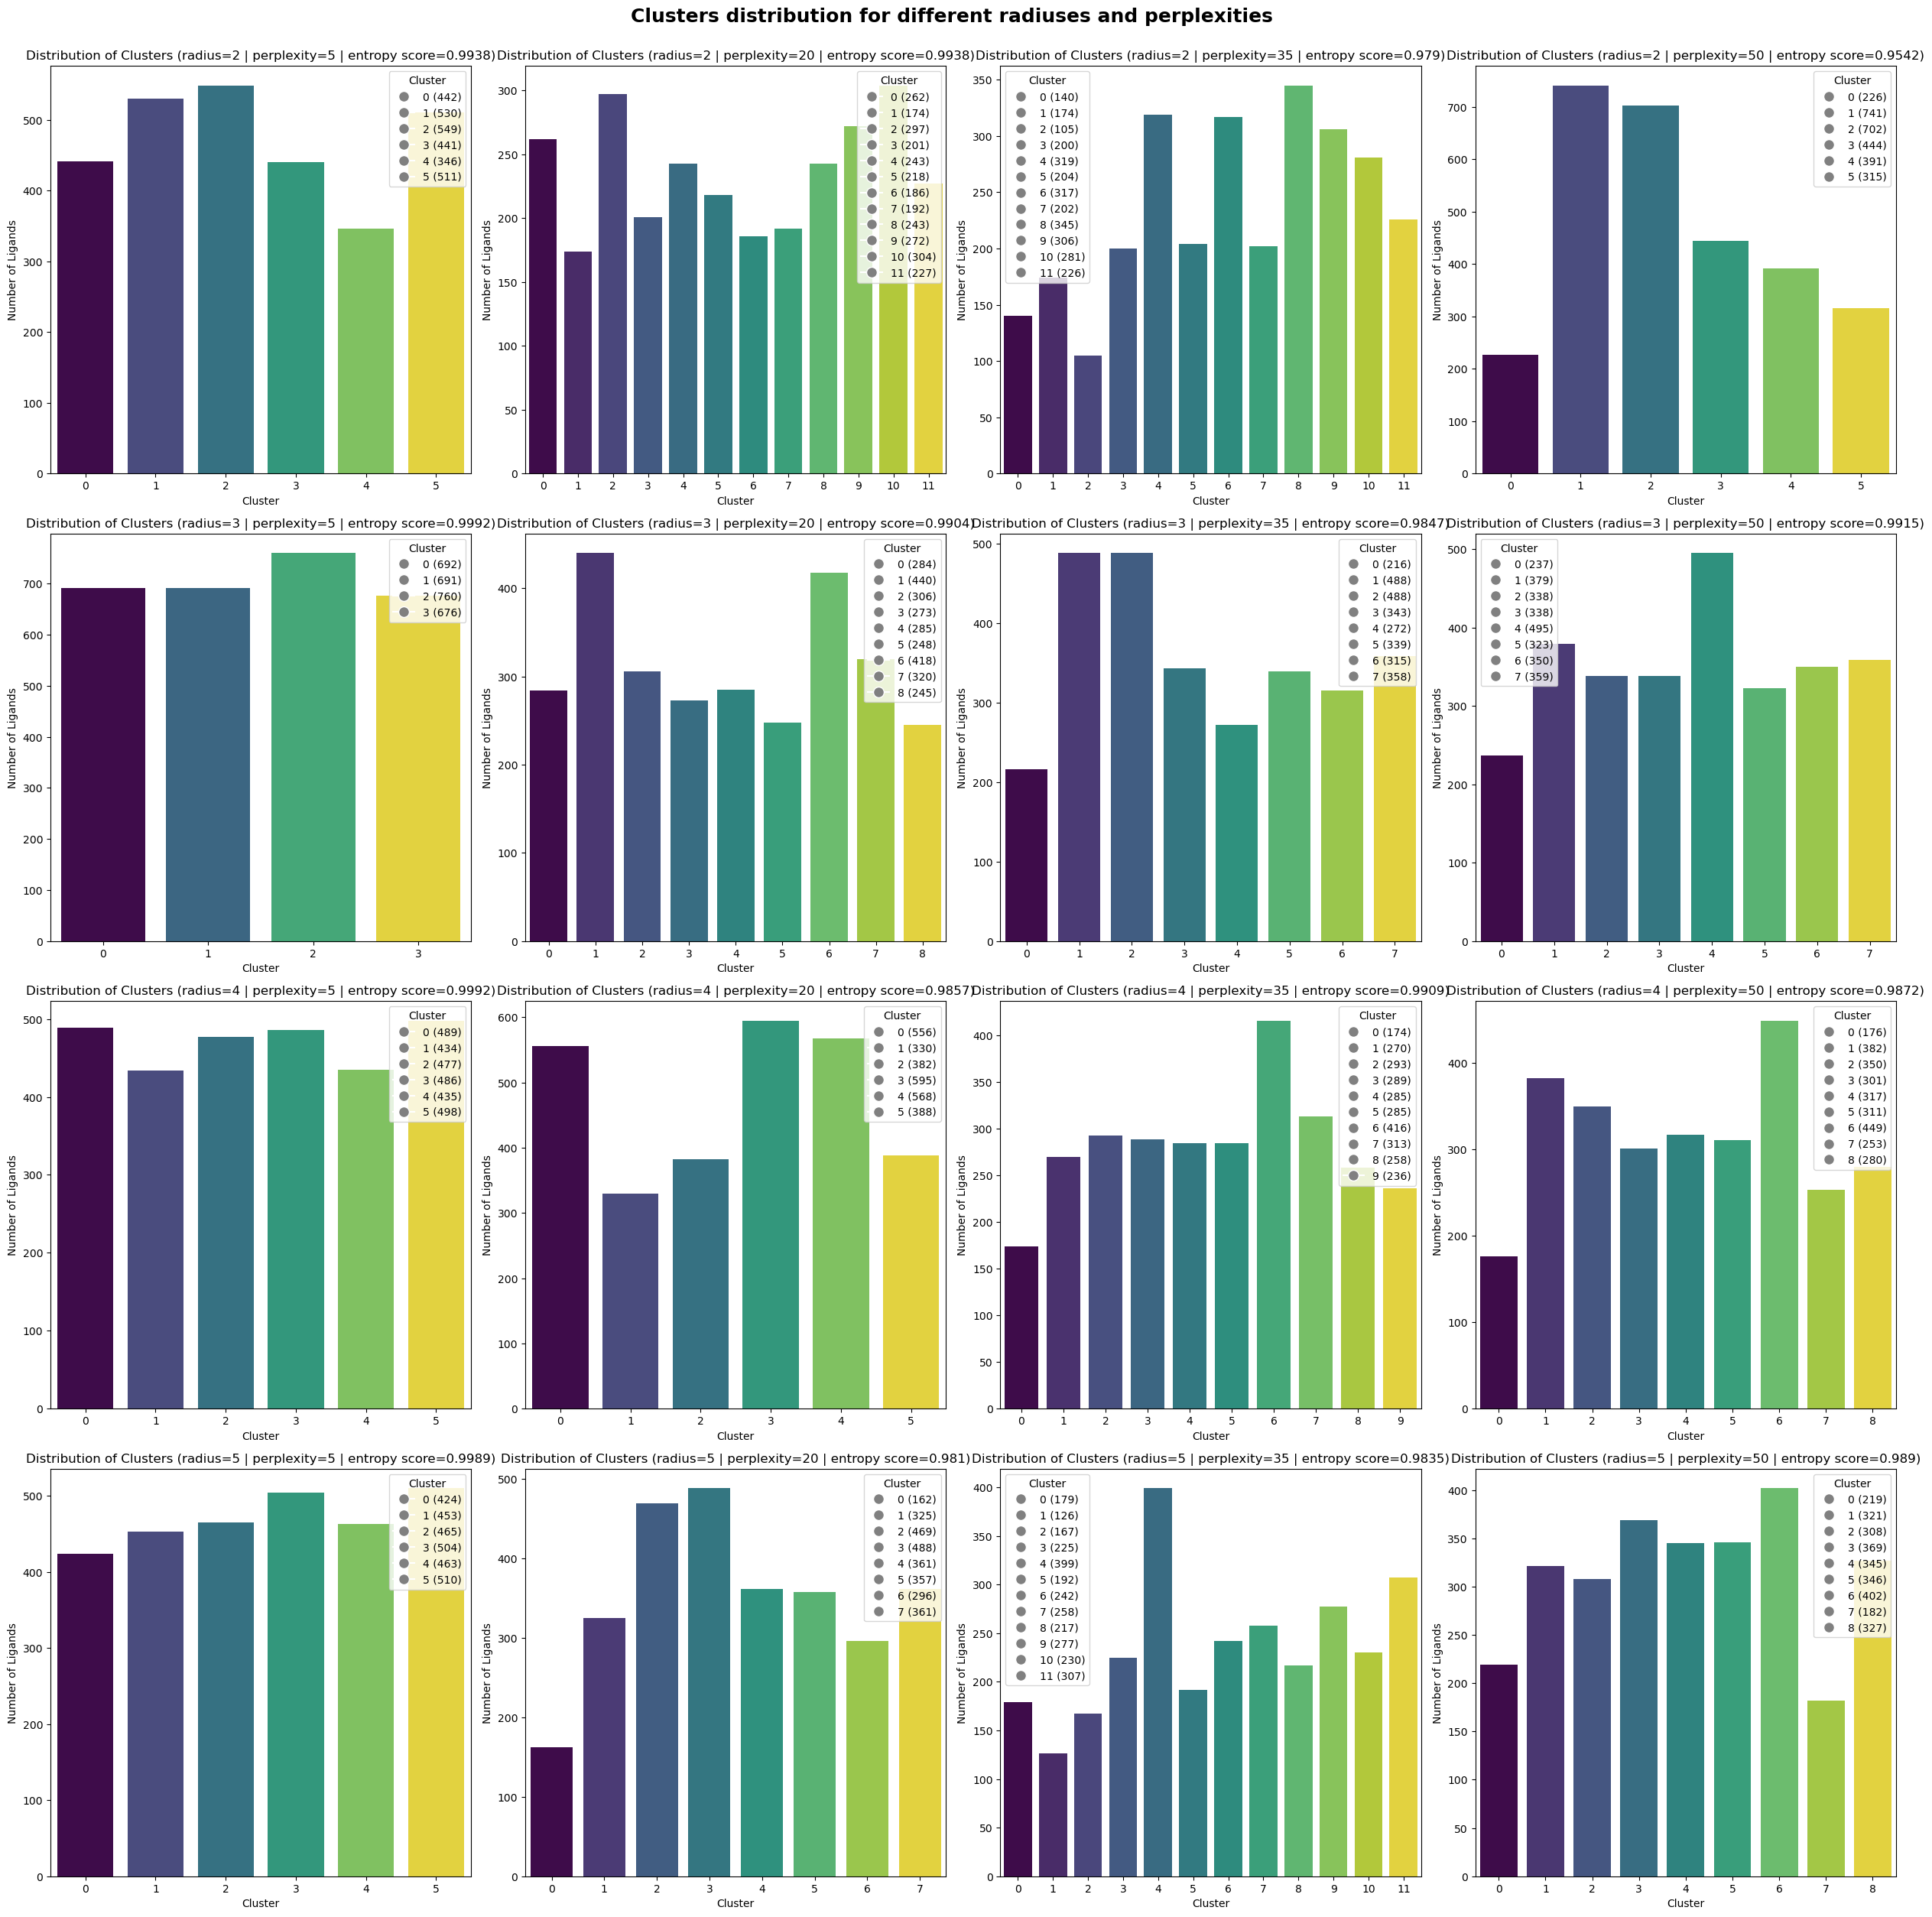

In [16]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities"
)

#### Choose best cluster according to KL metric and check them in reduced spatial representation ####

In [ ]:
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'radius: {radiuses[idx_r]} | perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')

radius: 2 | perplexity: 5 | KL score: 0.5613718032836914
radius: 2 | perplexity: 20 | KL score: 0.5116504430770874
radius: 2 | perplexity: 35 | KL score: 0.5049332976341248
radius: 2 | perplexity: 50 | KL score: 0.4930573105812073
radius: 3 | perplexity: 5 | KL score: 0.5668769478797913
radius: 3 | perplexity: 20 | KL score: 0.5250749588012695
radius: 3 | perplexity: 35 | KL score: 0.5210806727409363
radius: 3 | perplexity: 50 | KL score: 0.5242923498153687
radius: 4 | perplexity: 5 | KL score: 0.5631123185157776
radius: 4 | perplexity: 20 | KL score: 0.5208603143692017
radius: 4 | perplexity: 35 | KL score: 0.531927764415741
radius: 4 | perplexity: 50 | KL score: 0.5496487617492676
radius: 5 | perplexity: 5 | KL score: 0.5546144247055054
radius: 5 | perplexity: 20 | KL score: 0.5322427153587341
radius: 5 | perplexity: 35 | KL score: 0.5545495748519897
radius: 5 | perplexity: 50 | KL score: 0.5746510028839111


In [ ]:
# use KL (Kullback-Leibler divergence) or choose manually 

MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (0,3)
else:
    min_index_flat = np.argmin(KLs)
    min_index = np.unravel_index(min_index_flat, KLs.shape)
k = best_ks[min_index[0]][min_index[1]]
print(min_index)

In [ ]:
TSNE_MF_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

### Using UMAP: Generate Fingerprints + Compute and Plot Scores ###

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


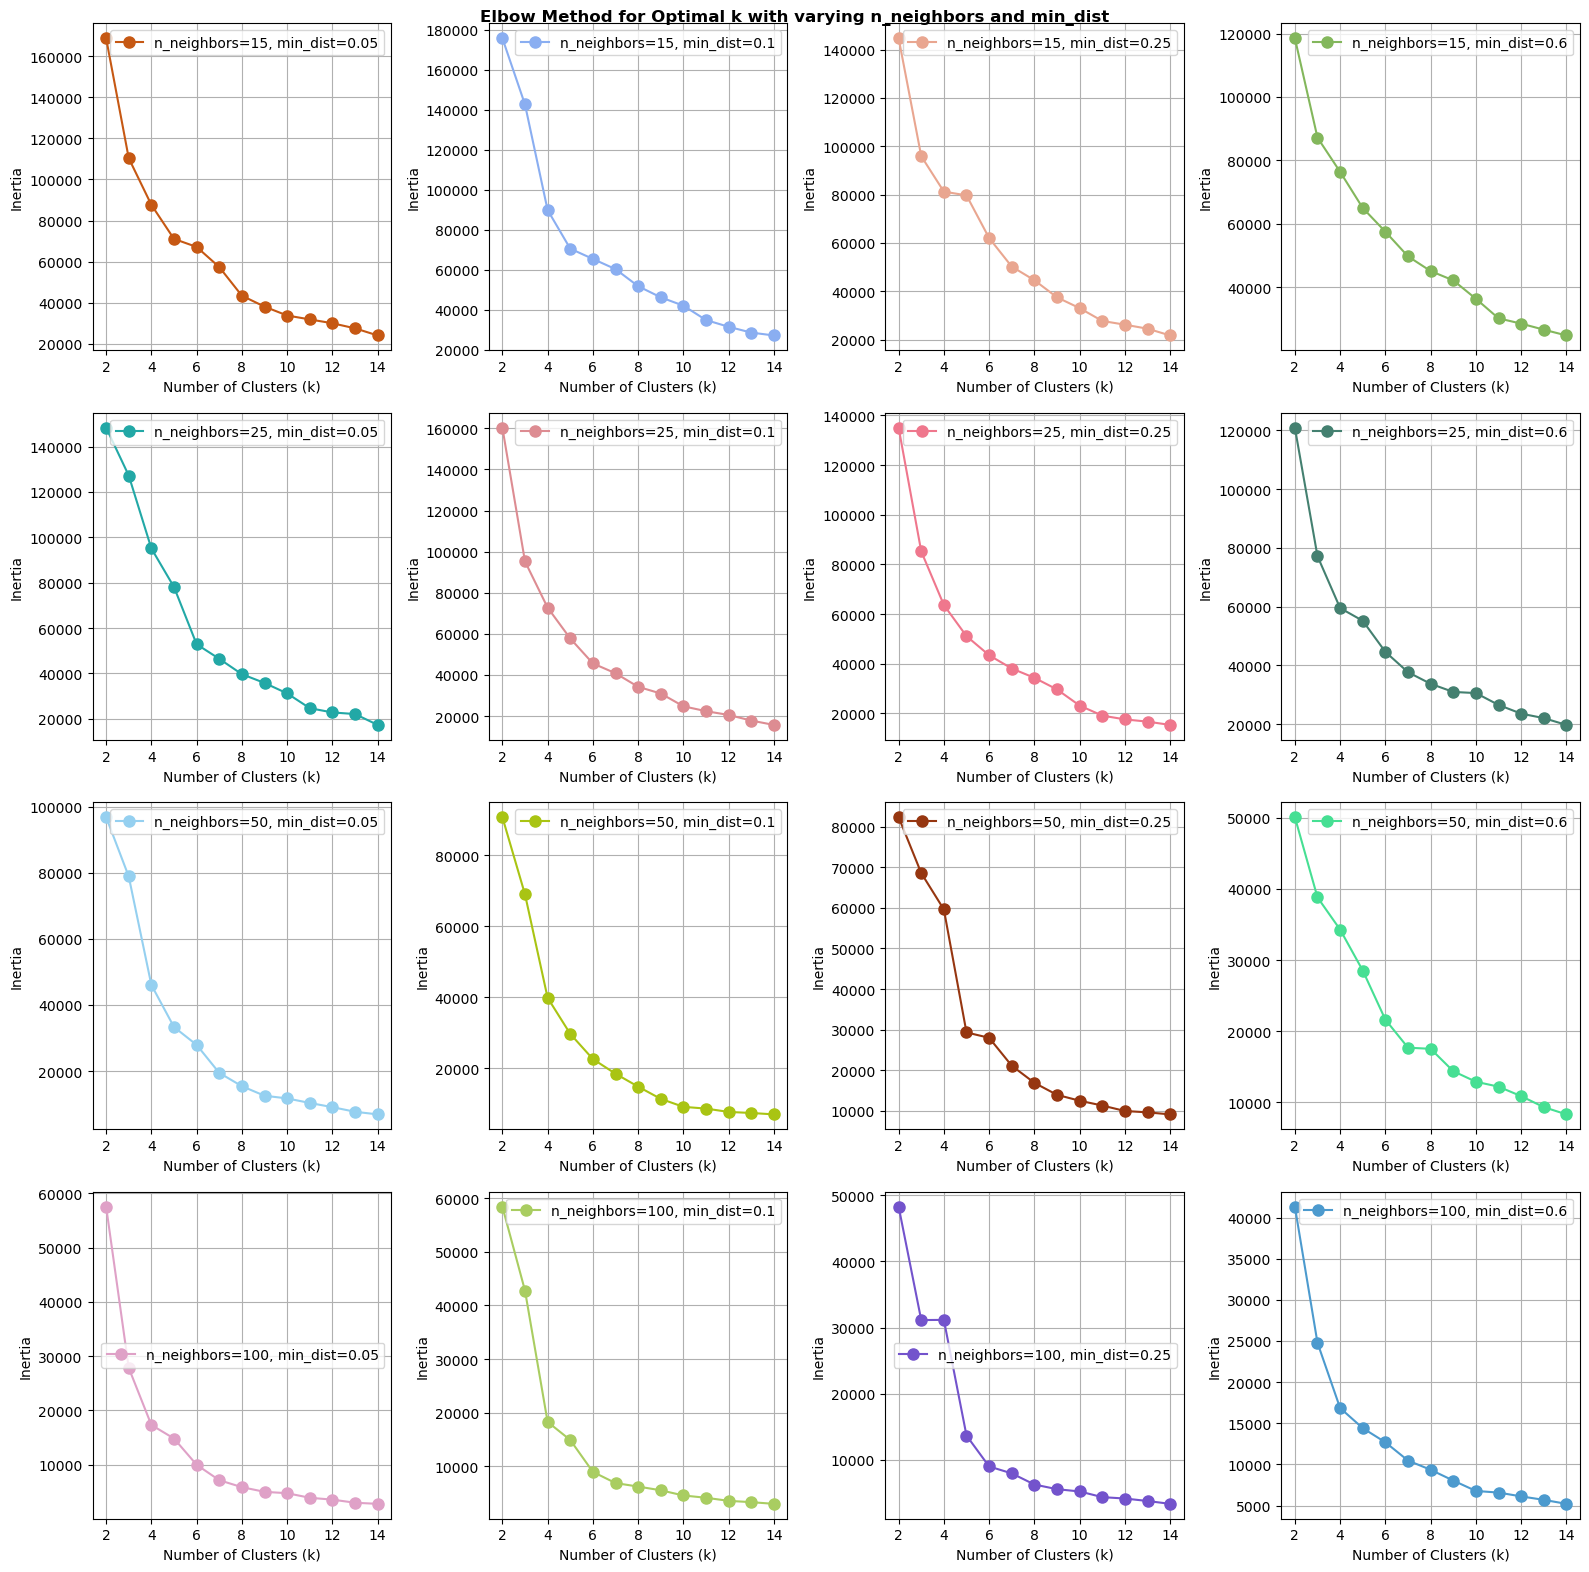

In [ ]:
# Important parameters for UMAP are the minimum number of neighbors and the minimum distance between neighbors.
# We don't tune the radius for Morgan Fingerprints as this would clotter the analysis. Instead we take the one that performed best
# in t-SNE (default is put to 3 in the implementations)

l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
    method='umap',
    original_data=smiles_list,
    param1_list=l_n_neighbors,
    param2_list=min_dists,
    Ks=Ks,
    param1_name='n_neighbors',
    param2_name='min_dist',
    metric='jaccard',
    generate_MF=True
)

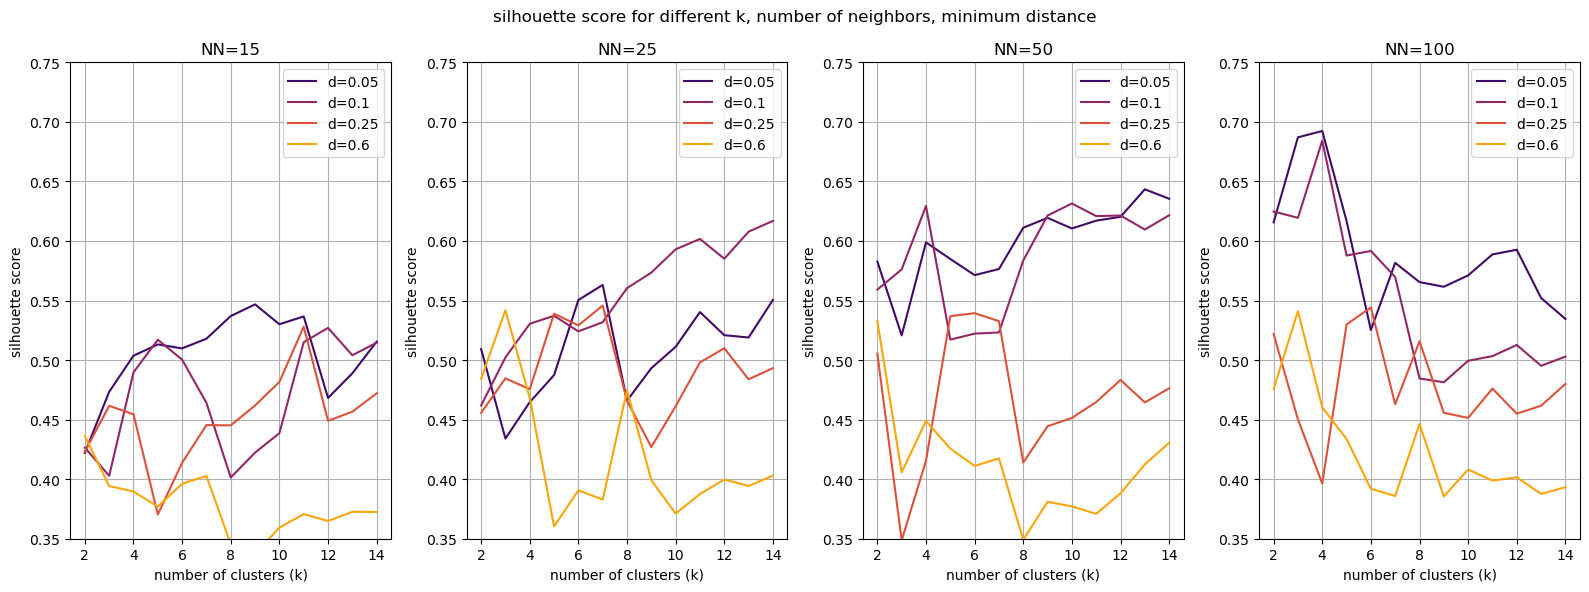

In [20]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.35, 0.75),
    color_palette="inferno", title="silhouette score for different k, number of neighbors, minimum distance"
)

In [ ]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[7,6,8,7],
           [10,12,6,4],
           [5,4,4,2],
           [4,4,4,2]]

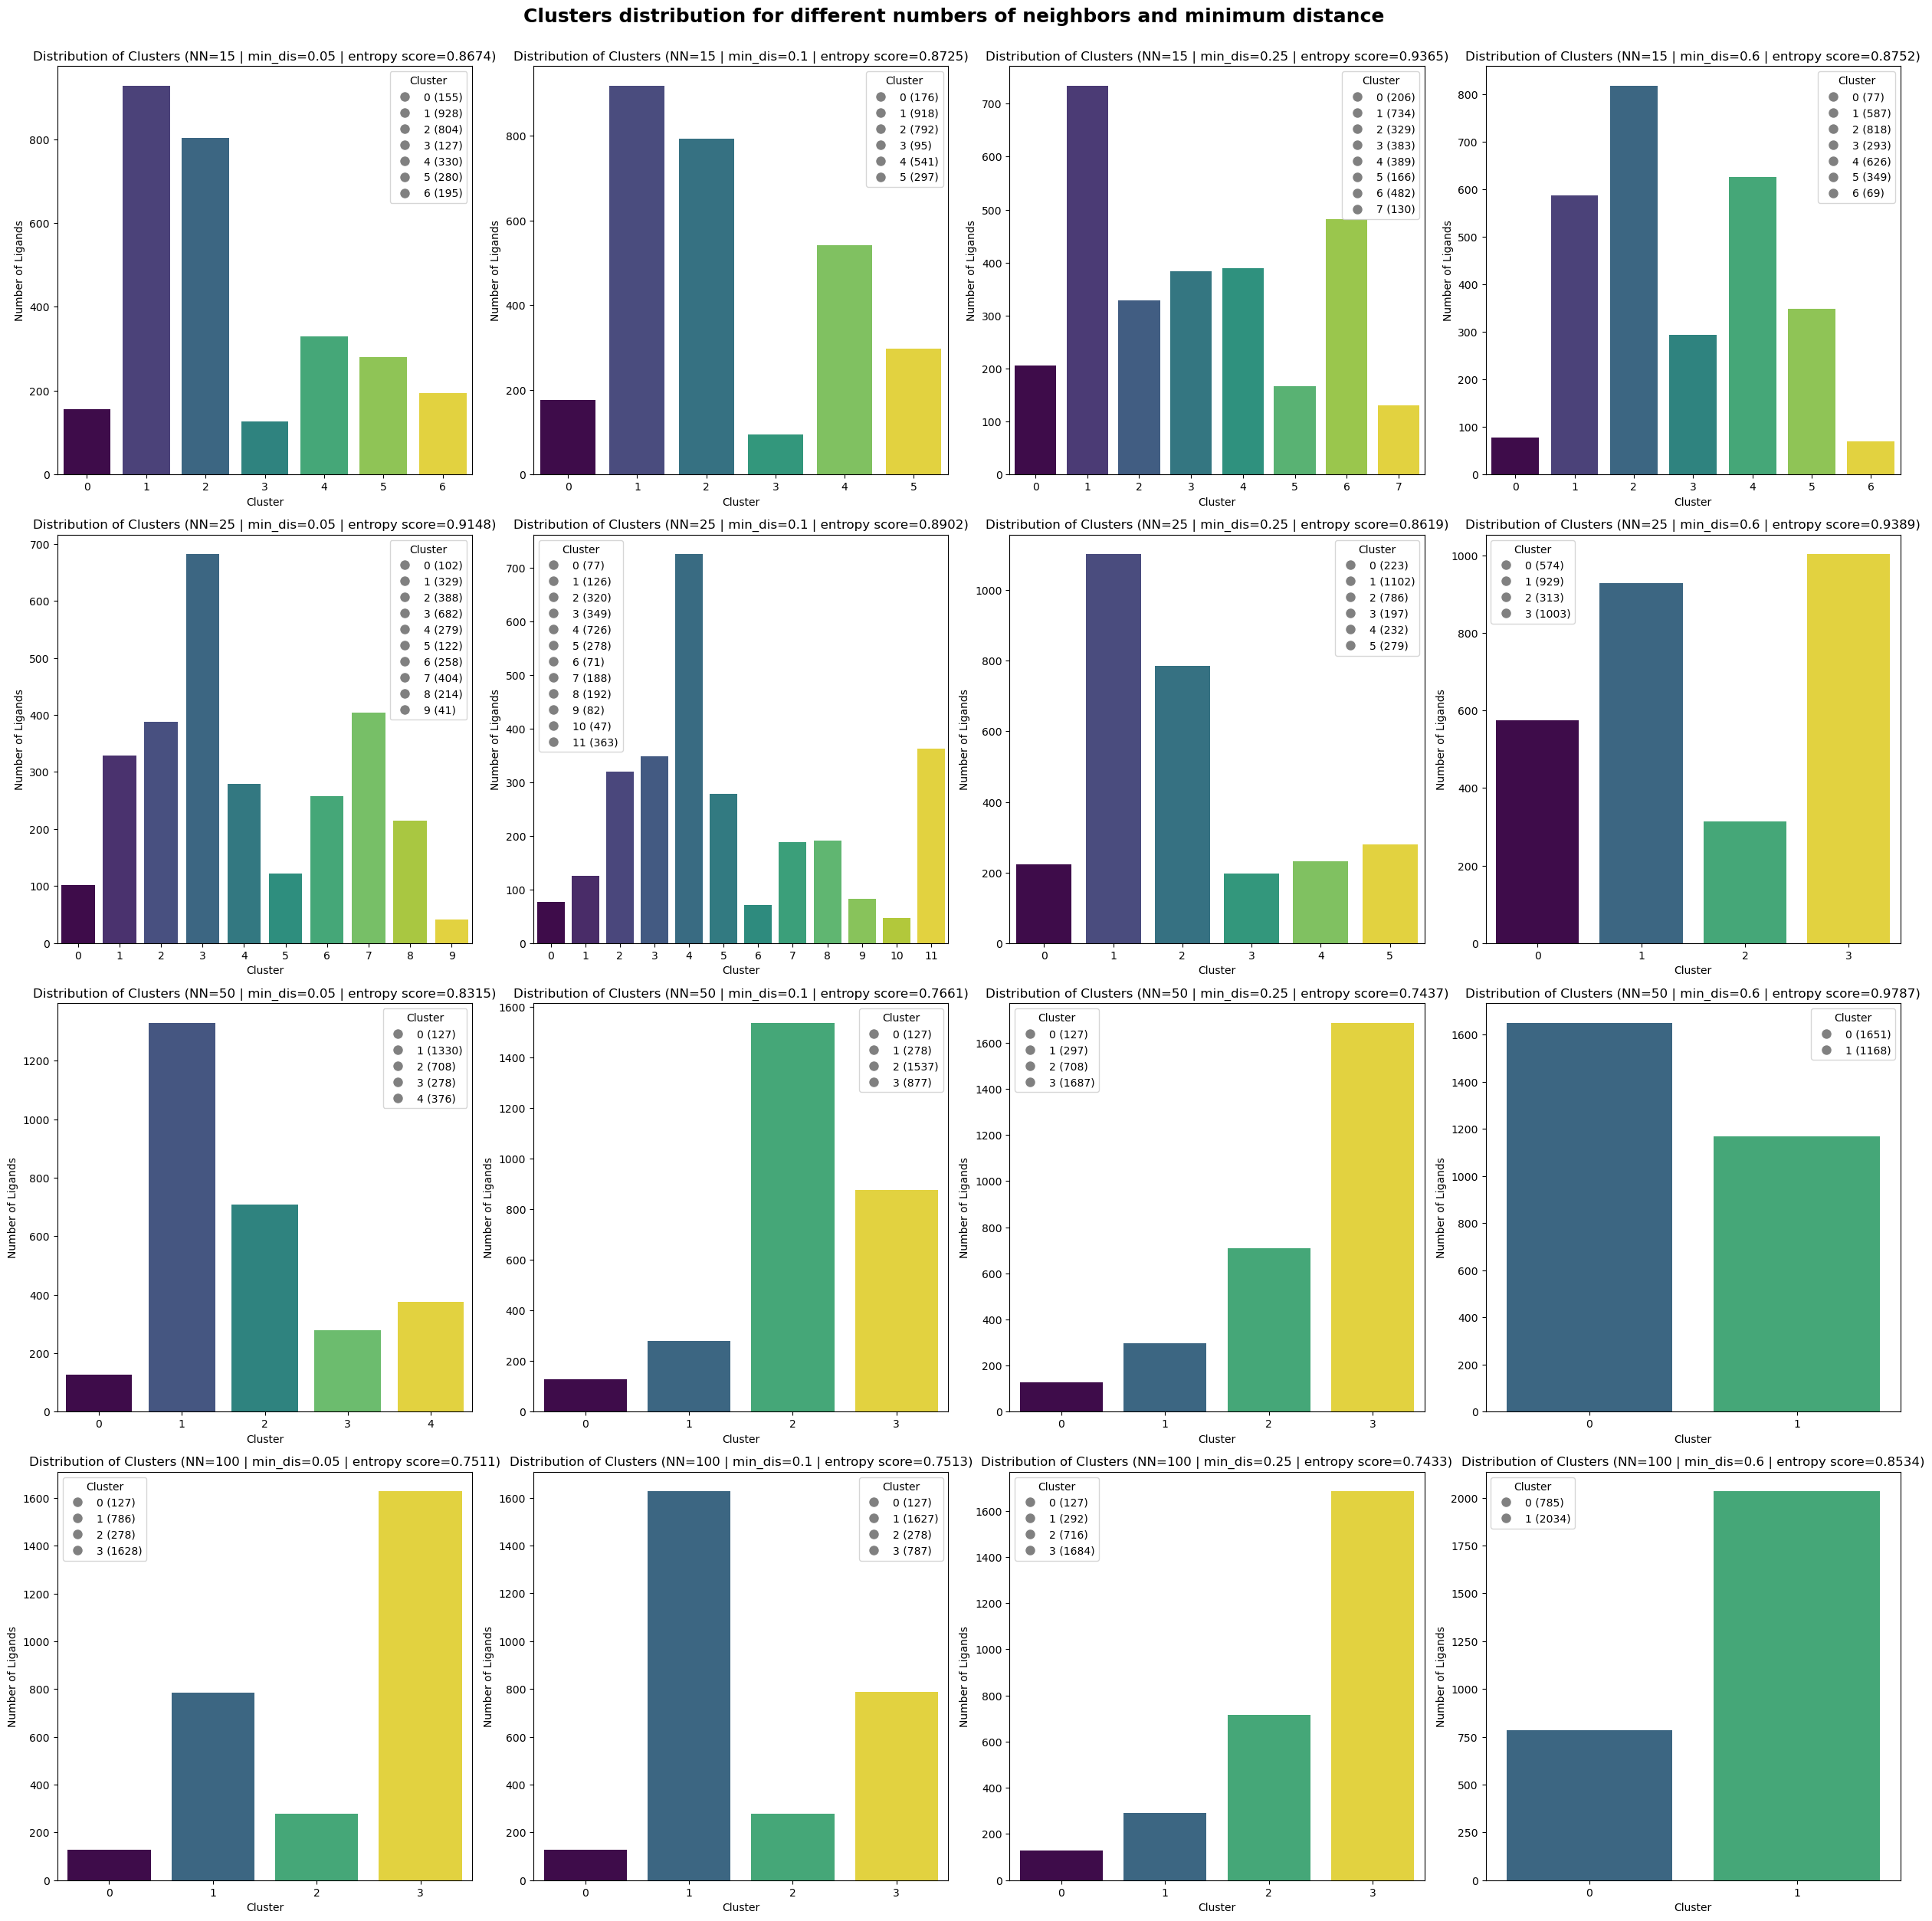

In [22]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_dis',
    title="Clusters distribution for different numbers of neighbors and minimum distance"
)

In [23]:
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'NN: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trustworthiness score: {trust_scores[idx_n][idx_d]}')

NN: 15 | minimum distance: 0.05 | trustworthiness score: 0.9596152580681231
NN: 15 | minimum distance: 0.1 | trustworthiness score: 0.9609571047204549
NN: 15 | minimum distance: 0.25 | trustworthiness score: 0.9613470602693792
NN: 15 | minimum distance: 0.6 | trustworthiness score: 0.9611844096272264
NN: 25 | minimum distance: 0.05 | trustworthiness score: 0.9389918591914755
NN: 25 | minimum distance: 0.1 | trustworthiness score: 0.9384558906347601
NN: 25 | minimum distance: 0.25 | trustworthiness score: 0.940380846618065
NN: 25 | minimum distance: 0.6 | trustworthiness score: 0.9403236245954693
NN: 50 | minimum distance: 0.05 | trustworthiness score: 0.8863335073070581
NN: 50 | minimum distance: 0.1 | trustworthiness score: 0.8899878968335165
NN: 50 | minimum distance: 0.25 | trustworthiness score: 0.8980804562856913
NN: 50 | minimum distance: 0.6 | trustworthiness score: 0.8938884821312951
NN: 100 | minimum distance: 0.05 | trustworthiness score: 0.8293191447020649
NN: 100 | minimum 

In [ ]:
# use trustworthiness or choose manually 

MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (3,0)
else:
    min_index_flat = np.argmin(trust_scores)
    min_index = np.unravel_index(min_index_flat, trust_scores.shape)
k = best_ks[min_index[0]][min_index[1]]
print(min_index)

(3, 0)


In [ ]:
UMAP_MF_df = plot_3d_clusters(umap_results, min_index, k, method_name='UMAP')

## <b>Clustering with BERT Embeddings:</b> ##

Advantages:

- Effectively preserves both local and global structures.
- Suitable for various machine learning models.
- Captures complex relationships and dependencies, with a high number of features, making it highly effective for training complex models, provided overfitting is avoided.

Inconveniences:

- Computationally expensive.
- Difficult to interpret, unlike Morgan Fingerprints.
- Requires a large amount of data for optimal performance (in this case, we have approximately 2800 individual ligands).
- Prone to overfitting, though this can be mitigated through dimensionality reduction.

More info on BERT embedding can be found in the implementations.

Note: for dimension reduction of BERT embeddings, we will use cosine metric as it is suited for semantic relationships

#### Generating embeddings ####

In [ ]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"
model, tokenizer = get_BERT_model(model_name)

In [27]:
embeddings = np.zeros((len(smiles_list), 768))

for i in range(len(smiles_list)):
  inputs = tokenizer(smiles_list[i], padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  if i % 500 == 0:
    print(f'iteration {i}')
  embeddings[i] = outputs.last_hidden_state.mean(dim=1).numpy()

iteration 0
iteration 500
iteration 1000
iteration 1500
iteration 2000
iteration 2500


#### Using TSNE to reduce dimensions ####

Radius = 1
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


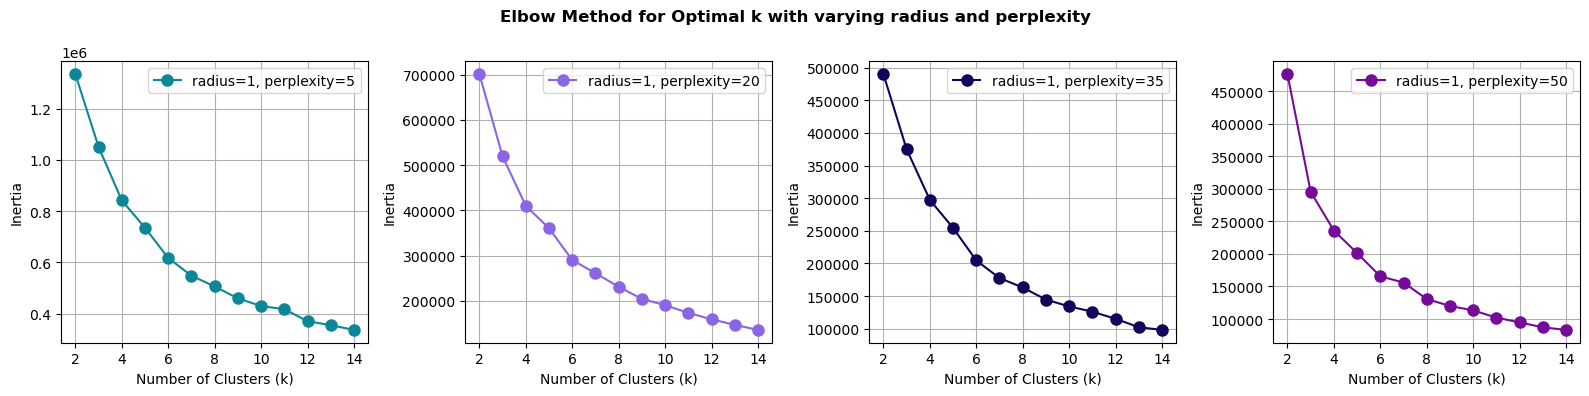

In [ ]:
# We don't need radius here as we do not use Morgan Fingerprints, but for the implementation it is necessary to still pass the parameter
radiuses = [3]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsne_results, KLs, s_scores = plot_elbow_curve(
                                                method='tsne',
                                                original_data=embeddings,
                                                param1_list=radiuses,
                                                param2_list=perplexities,
                                                Ks=Ks,
                                                param1_name='radius',
                                                param2_name='perplexity',
                                                metric='cosine'
                                                        )

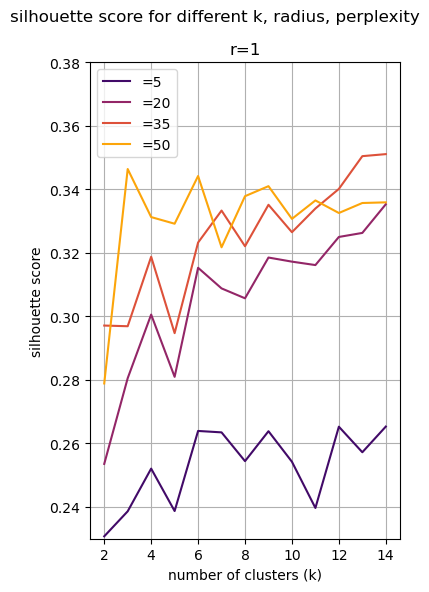

In [29]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='', y_lim=(0.23, 0.38),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

In [ ]:
# Choose best k for each perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,6,7,3]]

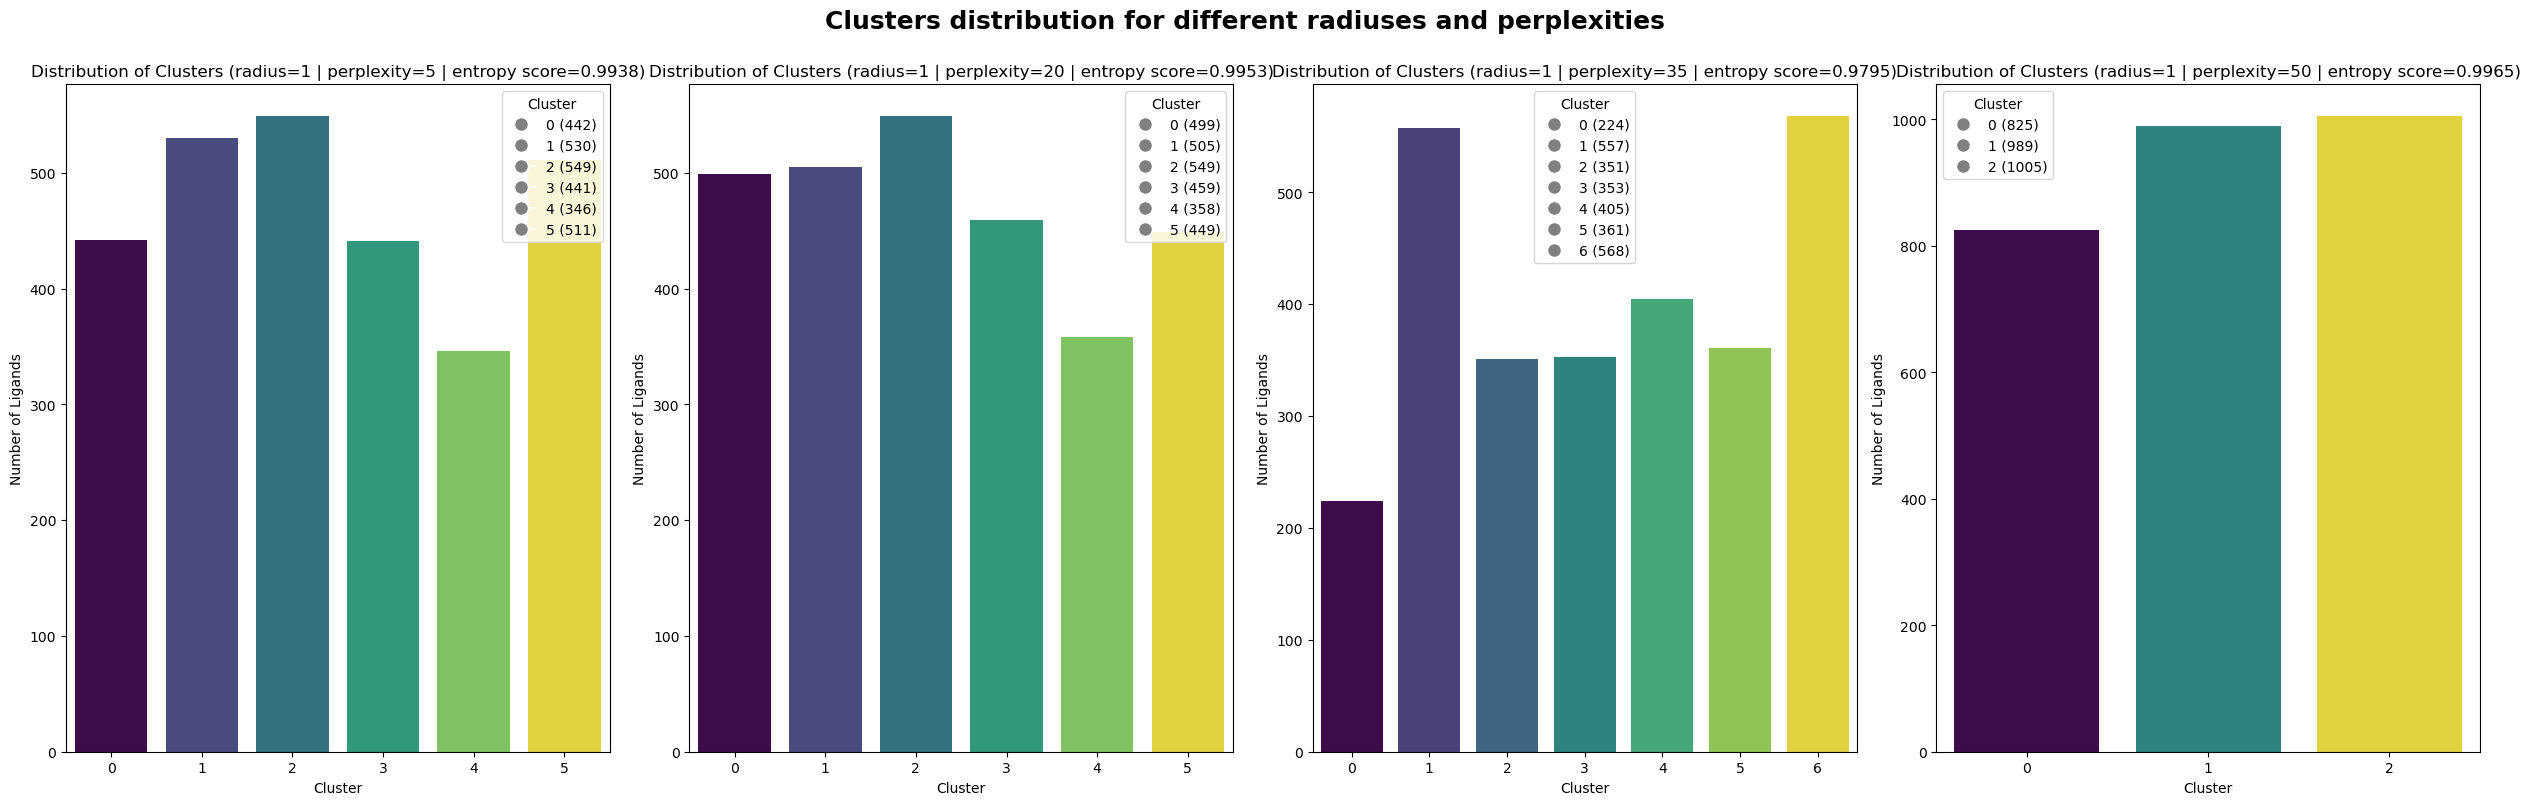

In [31]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities",
    figsize=(25,8)
)

In [ ]:
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')

perplexity: 5 | KL score: 0.4997440278530121
perplexity: 20 | KL score: 0.567436933517456
perplexity: 35 | KL score: 0.5777400732040405
perplexity: 50 | KL score: 0.5812215209007263


In [ ]:
# use KL or choose manually 

MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (0,3)
else:
    min_index_flat = np.argmin(KLs)
    min_index = np.unravel_index(min_index_flat, KLs.shape)
k = best_ks[min_index[0]][min_index[1]]
print(min_index)

(0, 3)


In [ ]:
TSNE_BERT_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

#### Using UMAP to reduce dimensions ####

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


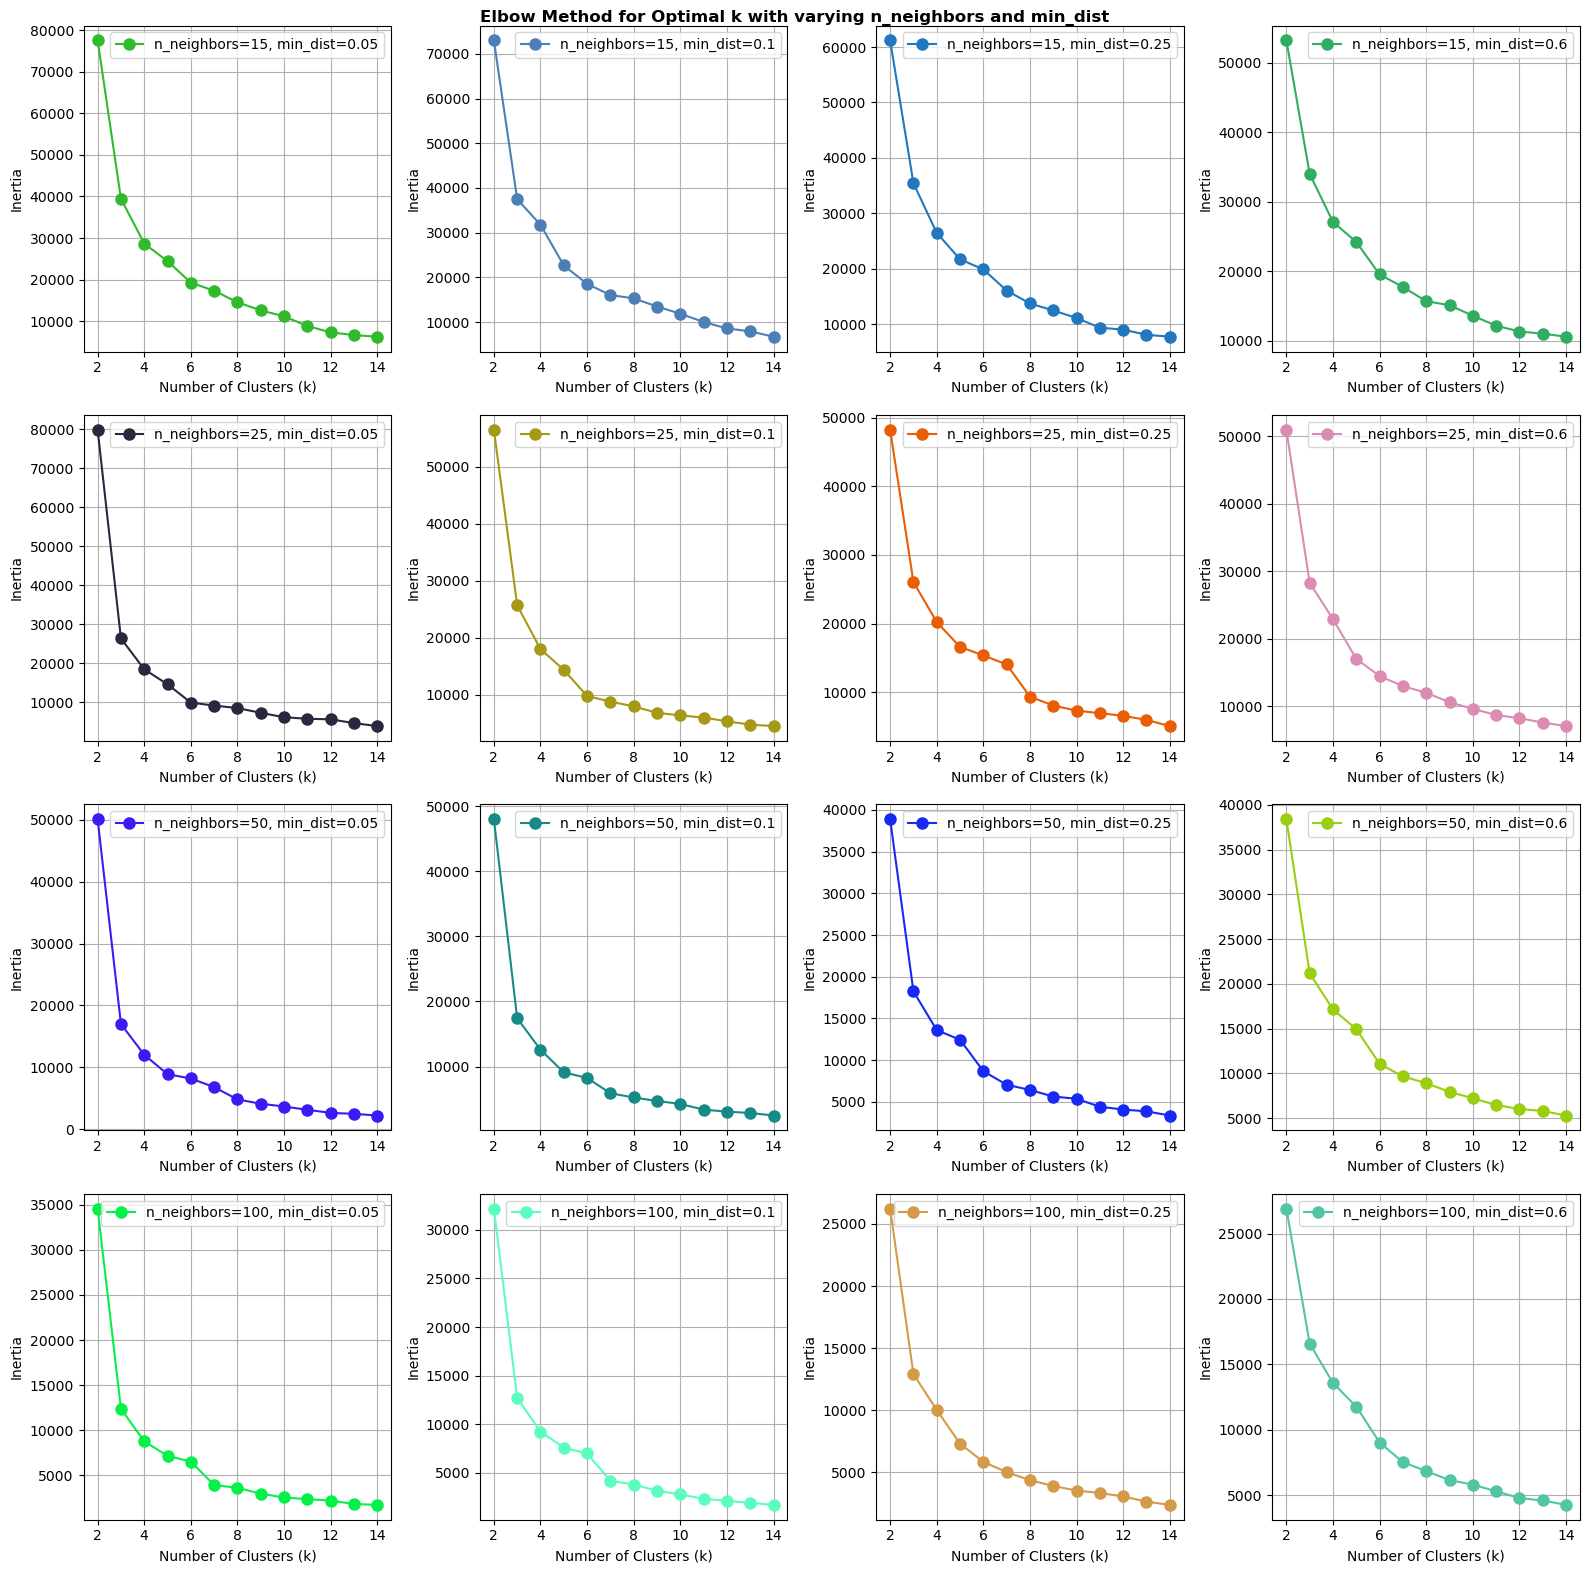

In [35]:
l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
                                                        method='umap',
                                                        original_data=embeddings,
                                                        param1_list=l_n_neighbors,
                                                        param2_list=min_dists,
                                                        Ks=Ks,
                                                        param1_name='n_neighbors',
                                                        param2_name='min_dist',
                                                        metric='cosine'
                                                        )

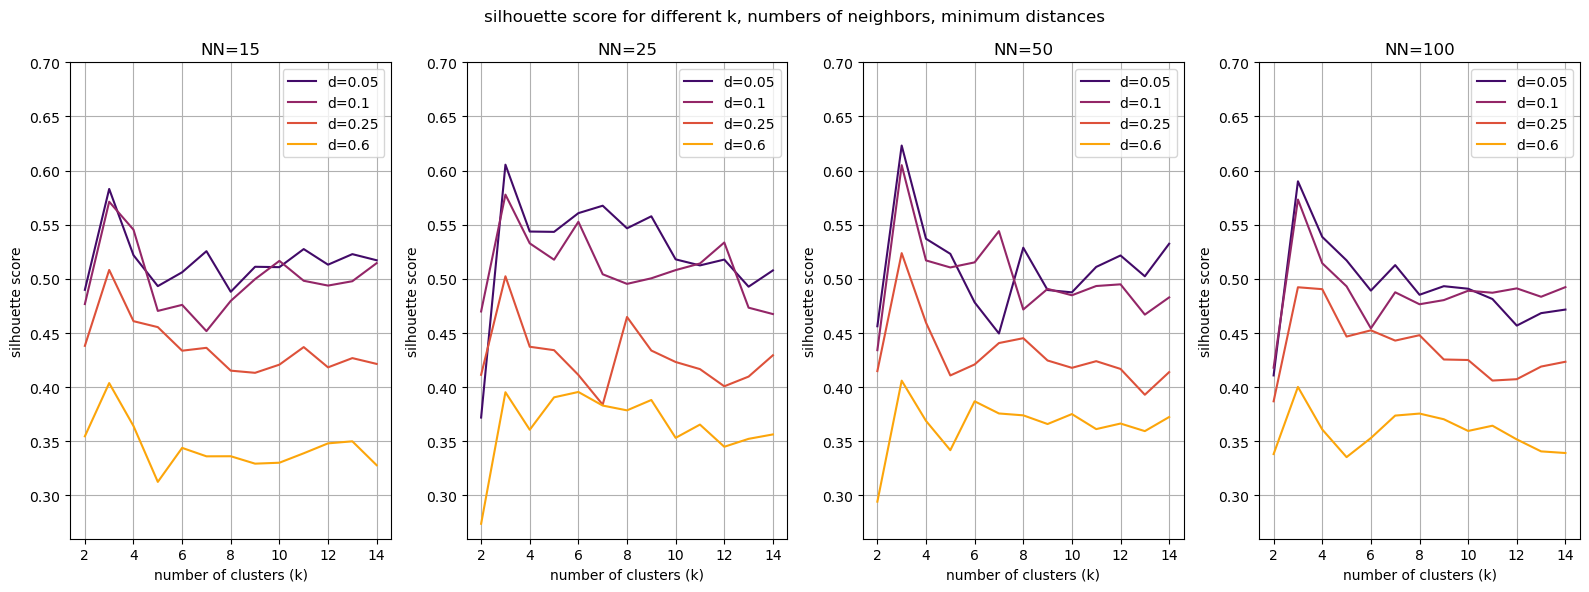

In [36]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.26, 0.7),
    color_palette="inferno", title="silhouette score for different k, numbers of neighbors, minimum distances"
)

In [ ]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[3,3,3,4],
           [3,3,3,5],
           [3,3,3,4],
           [3,3,4,3]]

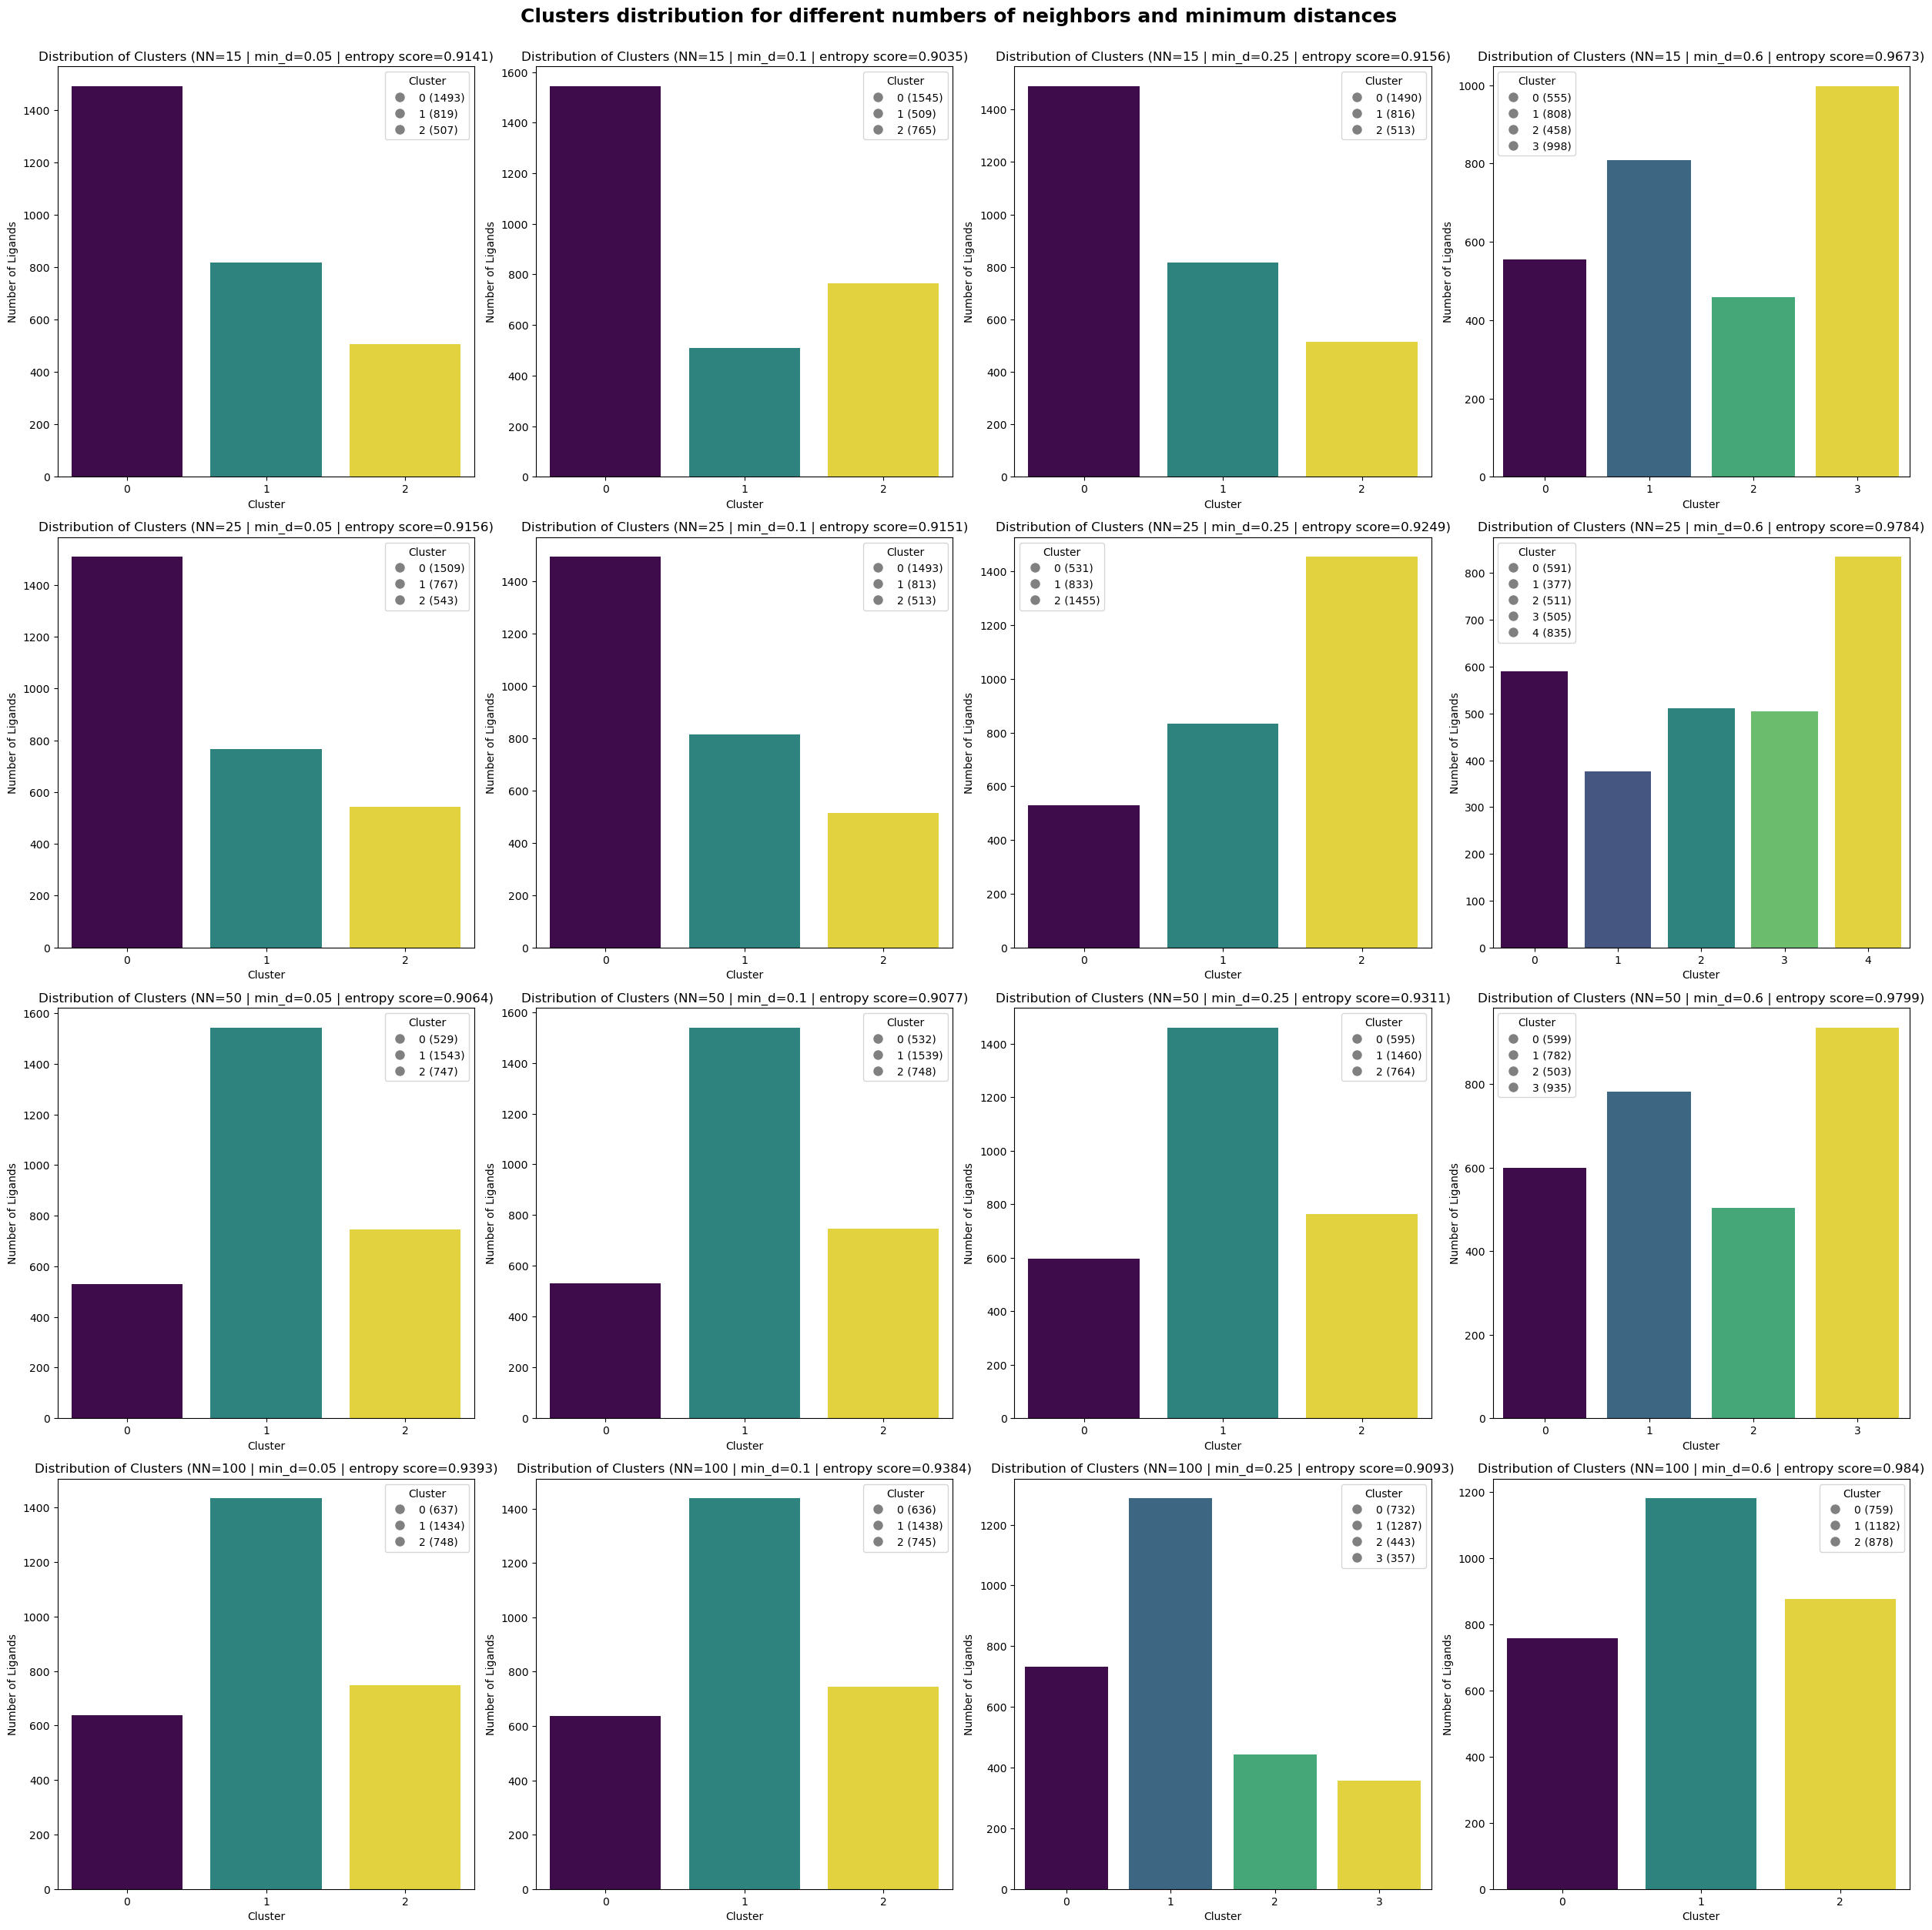

In [38]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_d', figsize=(25,25),
    title="Clusters distribution for different numbers of neighbors and minimum distances"
)

In [ ]:
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'NN: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trustworthiness score: {trust_scores[idx_n][idx_d]}')

NN: 15 | minimum distance: 0.05 | trustworthiness score: 0.9837210897576107
NN: 15 | minimum distance: 0.1 | trustworthiness score: 0.9851751678904795
NN: 15 | minimum distance: 0.25 | trustworthiness score: 0.9848848834370897
NN: 15 | minimum distance: 0.6 | trustworthiness score: 0.9847358335350608
NN: 25 | minimum distance: 0.05 | trustworthiness score: 0.9751588612689946
NN: 25 | minimum distance: 0.1 | trustworthiness score: 0.9749638931078332
NN: 25 | minimum distance: 0.25 | trustworthiness score: 0.975623979624572
NN: 25 | minimum distance: 0.6 | trustworthiness score: 0.9715933450507096
NN: 50 | minimum distance: 0.05 | trustworthiness score: 0.957294815253287
NN: 50 | minimum distance: 0.1 | trustworthiness score: 0.9572653528579564
NN: 50 | minimum distance: 0.25 | trustworthiness score: 0.958541775642683
NN: 50 | minimum distance: 0.6 | trustworthiness score: 0.9584400291365582
NN: 100 | minimum distance: 0.05 | trustworthiness score: 0.9368180252273794
NN: 100 | minimum di

In [ ]:
# use trustworthiness score or choose manually

MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (2,0)
else:
    min_index_flat = np.argmin(trust_scores)
    min_index = np.unravel_index(min_index_flat, trust_scores.shape)
k = best_ks[min_index[0]][min_index[1]]
print(min_index)

In [ ]:
UMAP_BERT_df = plot_3d_clusters(umap_results, (2,0), k, method_name='UMAP')

UMAP1     UMAP2     UMAP3  Cluster
0     10.132277  8.315263  5.712197        2
1      9.768409  8.014274  7.860929        2
2      9.970960  8.592063  6.095190        2
3      9.077592  9.025949  3.669617        2
4      9.042576  9.047370  3.649172        2
...         ...       ...       ...      ...
2814  11.176159  2.581147  5.747248        1
2815   2.992100  1.523019  5.352967        0
2816   2.775399  1.389431  5.466144        0
2817   3.090873  1.069363  5.796077        0
2818   0.996329 -0.142525  5.588467        0

[2819 rows x 4 columns]